# Overview

This project is about detecting cyber attacks over a wifi network and how I developed a classifier with (relatively) high recall (0.83). In this dataset, wifi activity is classified as either normal, flooding, injection or impersonation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline

In [2]:
from classification_model.processing.data_management import load_dataset

In [3]:
train_orig = load_dataset(file_name='AWID-CLS-R-Trn.csv')
test_orig = load_dataset(file_name='AWID-CLS-R-Tst.csv')

## Data

With almost 1.8 million rows and 155 columns even the reduced data set is too large to explore each individual case. Exploring the meaning of the columns is more feasible but I will leave out most of that exploration.

The data from this project is sourced from the AWID project (http://icsdweb.aegean.gr/awid/index.html). If you would like to use this data, please go to their website and ask for permission. The data is broken up into 4 different data sets, A larger data set (F) and a reduced version (R). For each dataset size, there is one that generalizes wifi activity into those mentioned earlier (CLS) and one that has more differentiation for each type of cyber attack (ATK). I will be focusing on the reduced dataset with more generalized classes for this project.

In [4]:
train_orig.shape

(1795574, 155)

In [5]:
test_orig.shape

(575642, 155)

The following cells show that the distribution of the target values are heavily imbalananced. To address this I apply downsampling on the target values. Upsampling isn't reasonable given that the 'normal' label has between 30 and 45 times as many instances as any other label.

In [6]:
train_orig['class'].value_counts()

normal           1633189
injection          65379
impersonation      48522
flooding           48484
Name: class, dtype: int64

In [7]:
test_orig['class'].value_counts()

normal           530784
impersonation     20079
injection         16682
flooding           8097
Name: class, dtype: int64

In [8]:
100*train_orig['class'].value_counts(normalize=True)

normal           90.956374
injection         3.641120
impersonation     2.702311
flooding          2.700195
Name: class, dtype: float64

In [9]:
100*test_orig['class'].value_counts(normalize=True)

normal           92.207309
impersonation     3.488105
injection         2.897982
flooding          1.406603
Name: class, dtype: float64

## Missing Data
From the plot, we can see that a lot of the features almost entirely consist of missing data. I expect many of these features will be removed after feature selection is applied. I plan to use a grid search on the feature selection process to determine what is the optimal number of features to remove. 

In [10]:
missing_data = pd.DataFrame()
missing_data['feature'] = train_orig.columns

missing = list(100*train_orig.isnull().mean())
missing_data['missing'] = missing

In [11]:
missing_data

,feature,missing
0,frame.interface_id,0.000000
1,frame.dlt,100.000000
2,frame.offset_shift,0.000000
3,frame.time_epoch,0.000000
4,frame.time_delta,0.000000
...,...,...
150,wlan.qos.bit4,91.833252
151,wlan.qos.txop_dur_req,91.833252
152,wlan.qos.buf_state_indicated_2,71.279323
153,data.len,50.291439


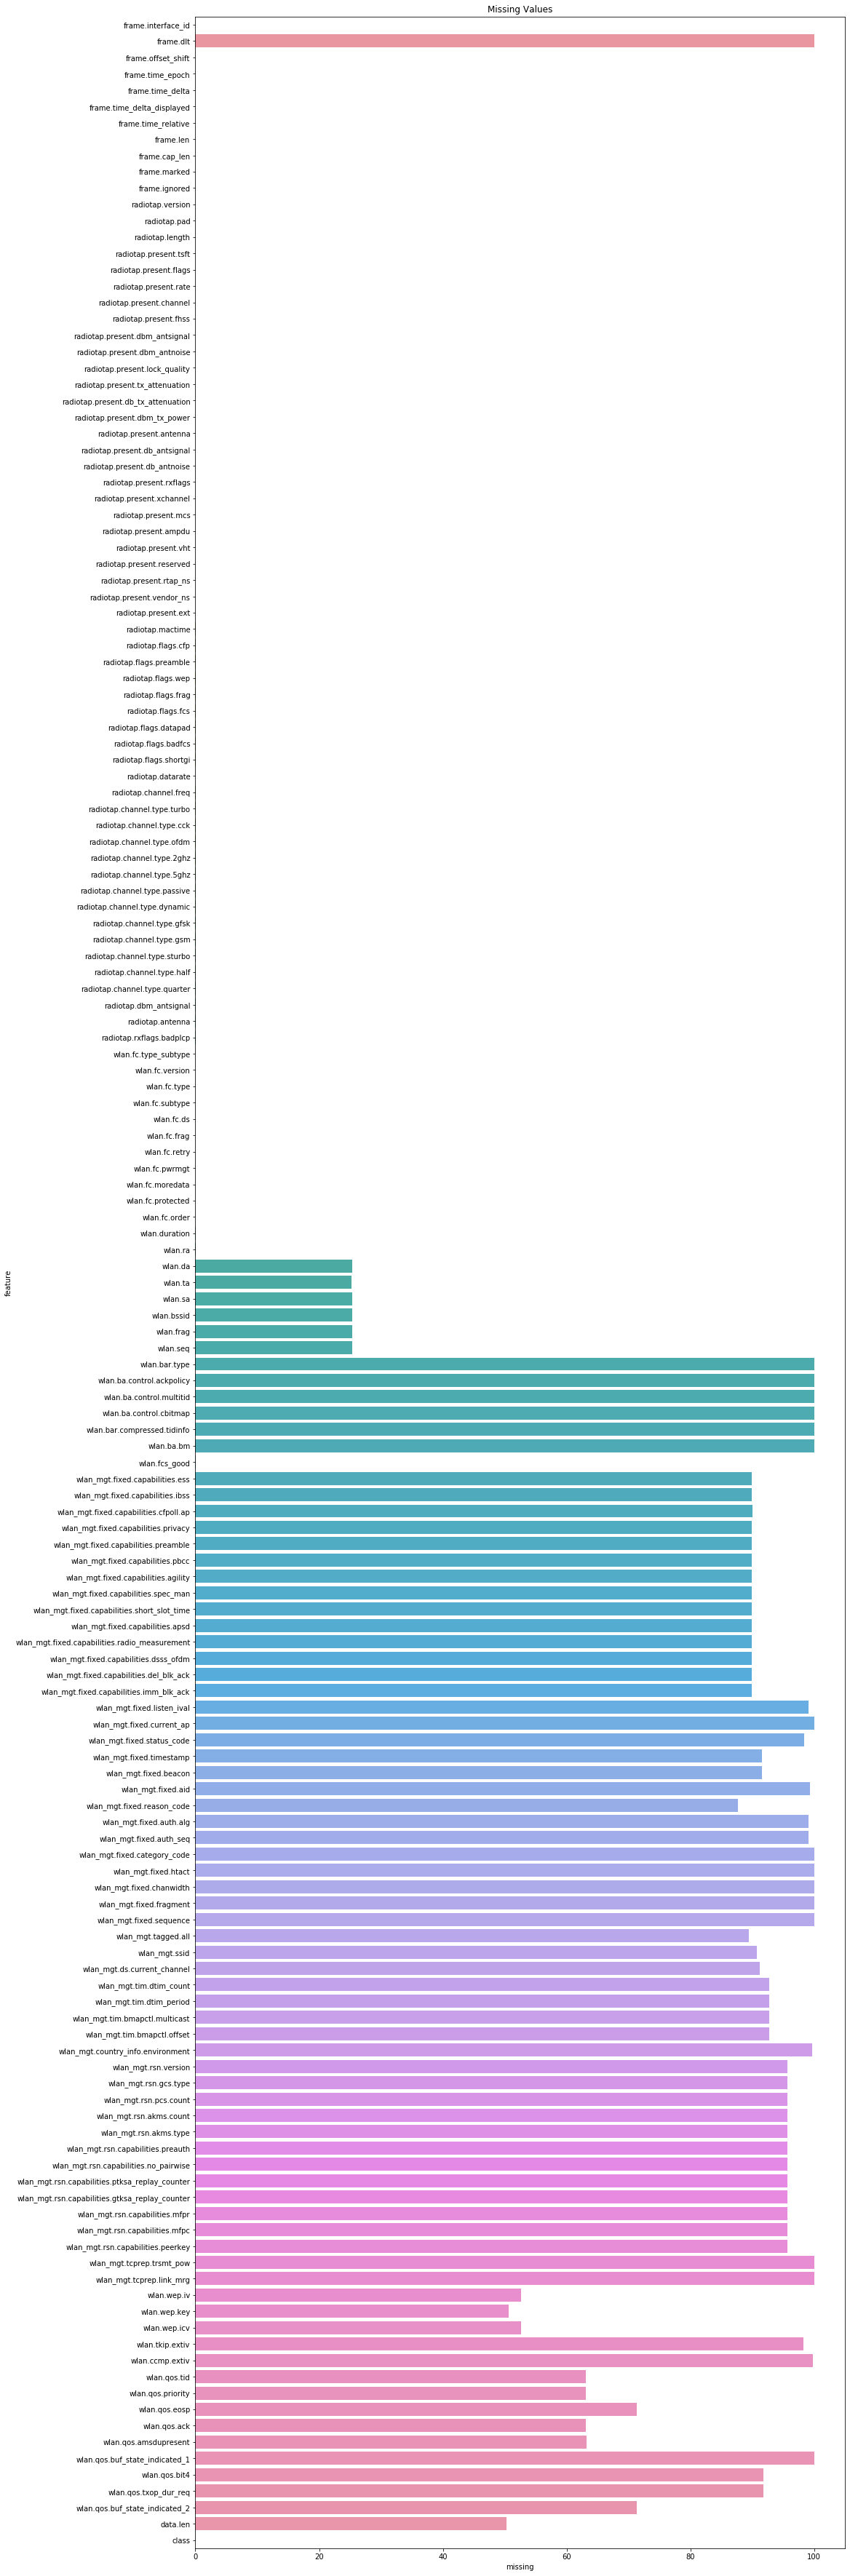

In [12]:
plt.figure(figsize=(16, 64))
sns.barplot(data=missing_data, x = 'missing', y = 'feature' );
plt.title('Missing Values');

The column names are difficult to interpret unless you are used to looking at wifi packet information. If you are interested, please look at https://www.wireshark.org/ for more information on these columns.

## Data Prep
A lot of data preparation is about to take place behind the scenes. For a complete description of all of the behind the scenes you can check out my code under the processing section to see what's happening under the hood of these functions. I will do my best to summarize many of the changes here.

Inside the prepare_data function I am replacing all missing values inside categorical variables with the label 'missing' as well as adjusting the time feature so that it is easier to measure. Later, you will see later that this data measures wifi traffic for an hour in the training set and approximately 20 minutes in the test set. I am also creating an integer feature that simply counts the seconds that have passed to use for aggregation. Why 1 second? Good question, I haven't yet done any analysis to determine if this is the best unit of time for aggregation, but it seemed like a good starting point. 

In [13]:
from tf_ann_model.processing.data_management import prepare_data

tt = pd.concat([train_orig, test_orig])

X_train, y_train = prepare_data(train_orig, train_data=True)
X_test, y_test = prepare_data(test_orig, train_data=False)
X_train_test, y_train_test = prepare_data(tt, train_data=False)

config.DOWNSAMPLE_DATA =  False
config.DOWNSAMPLE_DATA =  False
config.DOWNSAMPLE_DATA =  False


In [14]:
train = X_train.copy()
train['class'] = train_orig['class']

test = X_test.copy()
test['class'] = test_orig['class']

train_test = X_train_test.copy()
train_test['class'] = tt['class']

## Data Target Distribution

As you can see in the plots that follow there is a time dependency in the data for the target values flooding, injection, and impersonation.

In [15]:
def h(content):
    display(HTML(content))
    
def timehist(df, target, tcol, col, title = None, clipping=9999999999999999):
        
    df[df[target] == 'normal'].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 5), label='normal')
    df[df[target] == 'flooding'].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 5), label='flooding')
    df[df[target] == 'injection'].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 5), label='injection')
    df[df[target] == 'impersonation'].set_index(tcol)[col].clip(0, clipping).plot(style='.', figsize=(15, 5), label='impersonation')
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.show()
  

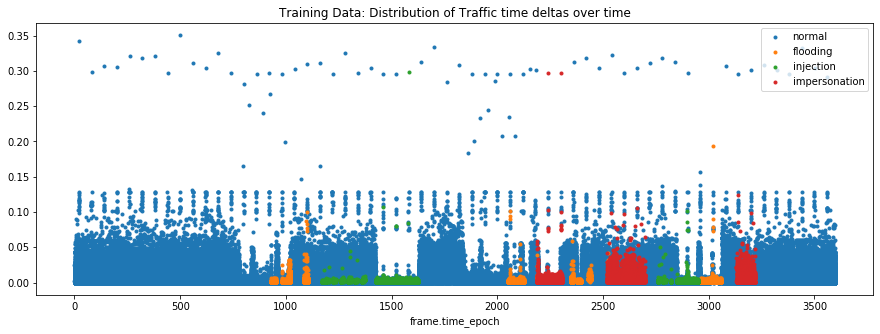

In [16]:
timehist(df=train, target='class', tcol='frame.time_epoch', col='frame.time_delta', title='Training Data: Distribution of Traffic time deltas over time')

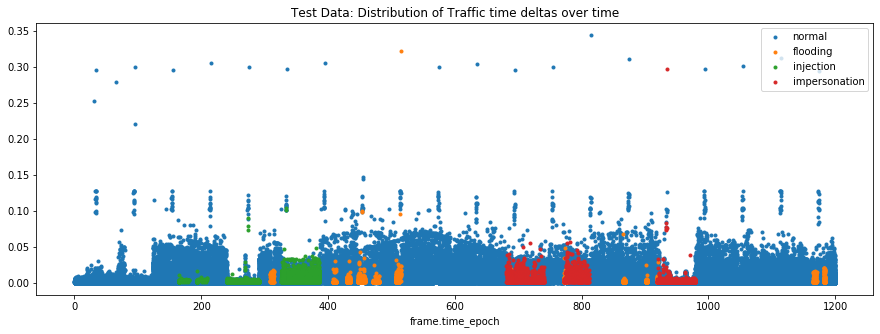

In [17]:
timehist(df=test, target='class', tcol='frame.time_epoch', col='frame.time_delta', title='Test Data: Distribution of Traffic time deltas over time')

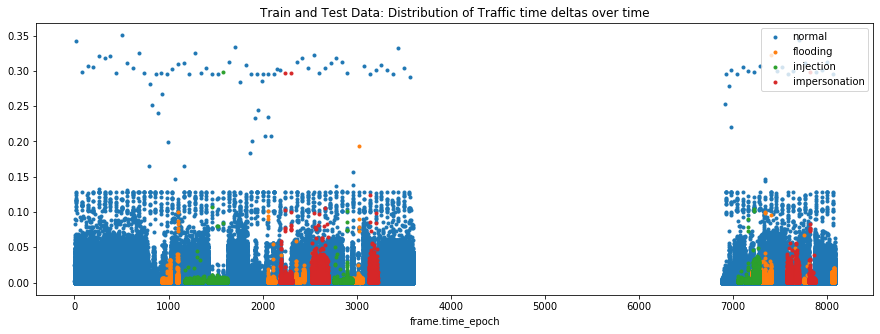

In [18]:
timehist(df=train_test, target='class', tcol='frame.time_epoch', col='frame.time_delta', title='Train and Test Data: Distribution of Traffic time deltas over time')

In [19]:
from classification_model.processing.data_management import partition_features
NUMERIC, CATEG = partition_features(X_train)

In [20]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

Feature: frame.interface_id

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: frame.interface_id, dtype: float64
 


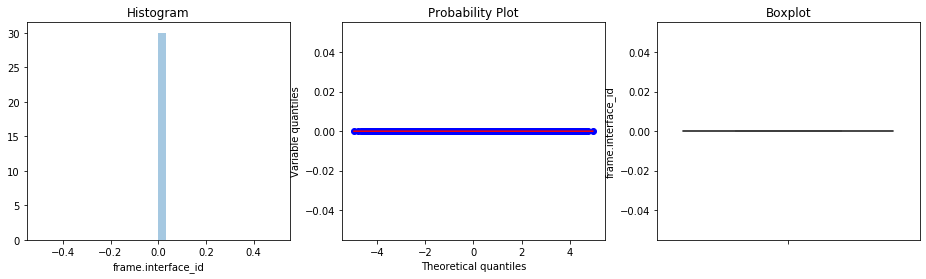

Feature: frame.dlt

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: frame.dlt, dtype: float64
 


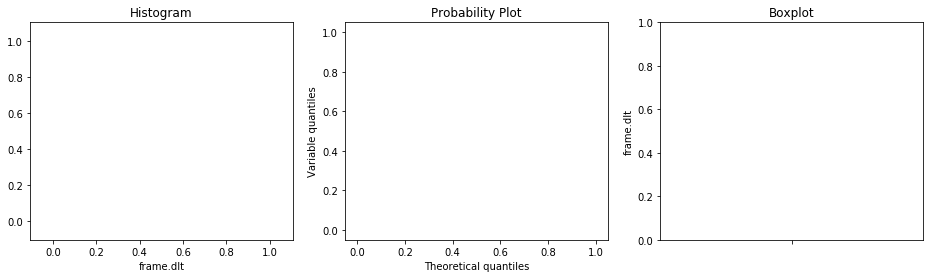

Feature: frame.offset_shift

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: frame.offset_shift, dtype: float64
 


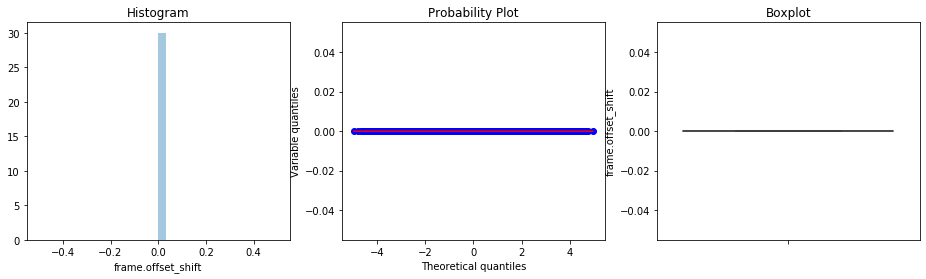

Feature: frame.time_epoch

count    1.795574e+06
mean     1.870271e+03
std      8.674439e+02
min      0.000000e+00
25%      1.027851e+03
50%      1.902590e+03
75%      2.524301e+03
max      3.599547e+03
Name: frame.time_epoch, dtype: float64
 


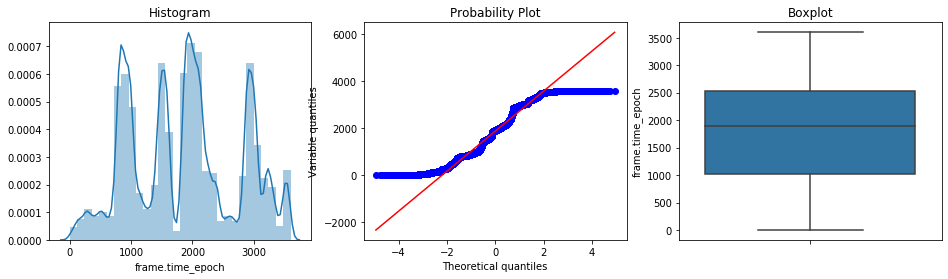

Feature: frame.time_delta

count    1.795574e+06
mean     2.004691e-03
std      6.379538e-03
min      1.000000e-06
25%      3.150000e-04
50%      5.490000e-04
75%      1.113000e-03
max      3.502630e-01
Name: frame.time_delta, dtype: float64
 


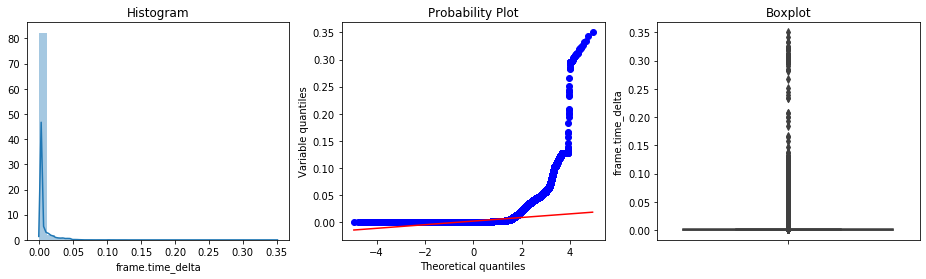

Feature: frame.time_delta_displayed

count    1.795574e+06
mean     2.004691e-03
std      6.379538e-03
min      1.000000e-06
25%      3.150000e-04
50%      5.490000e-04
75%      1.113000e-03
max      3.502630e-01
Name: frame.time_delta_displayed, dtype: float64
 


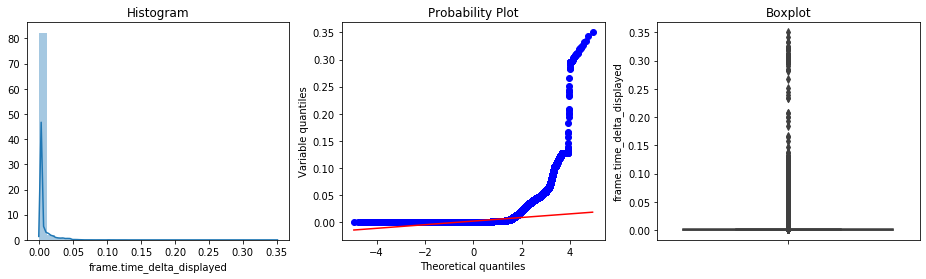

Feature: frame.time_relative

count    1.795574e+06
mean     1.870295e+03
std      8.674439e+02
min      2.427100e-02
25%      1.027876e+03
50%      1.902615e+03
75%      2.524325e+03
max      3.599571e+03
Name: frame.time_relative, dtype: float64
 


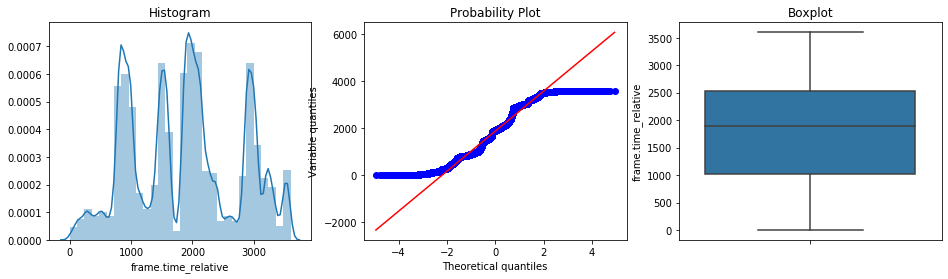

Feature: frame.len

count    1.795574e+06
mean     5.153151e+02
std      6.649246e+02
min      4.000000e+01
25%      4.000000e+01
50%      1.120000e+02
75%      1.552000e+03
max      1.570000e+03
Name: frame.len, dtype: float64
 


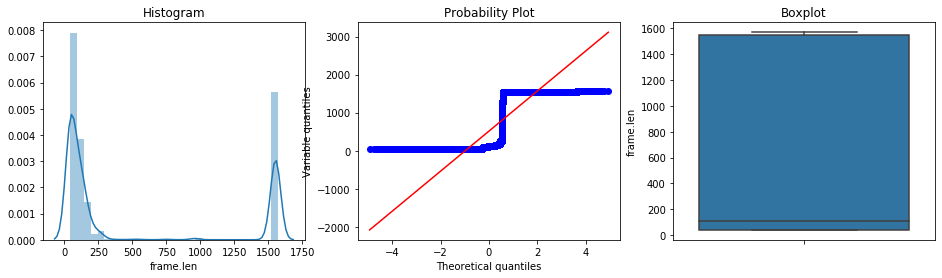

Feature: frame.cap_len

count    1.795574e+06
mean     5.153151e+02
std      6.649246e+02
min      4.000000e+01
25%      4.000000e+01
50%      1.120000e+02
75%      1.552000e+03
max      1.570000e+03
Name: frame.cap_len, dtype: float64
 


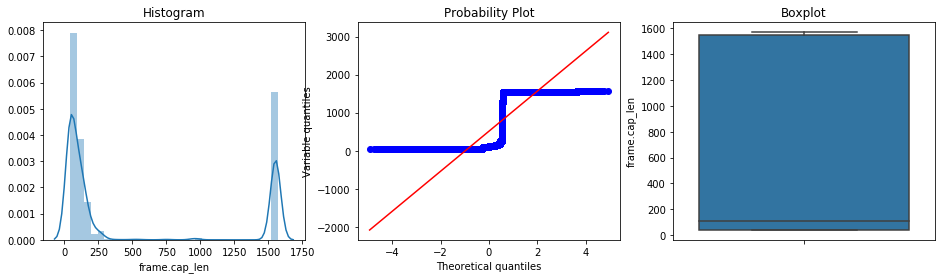

Feature: frame.marked

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: frame.marked, dtype: float64
 


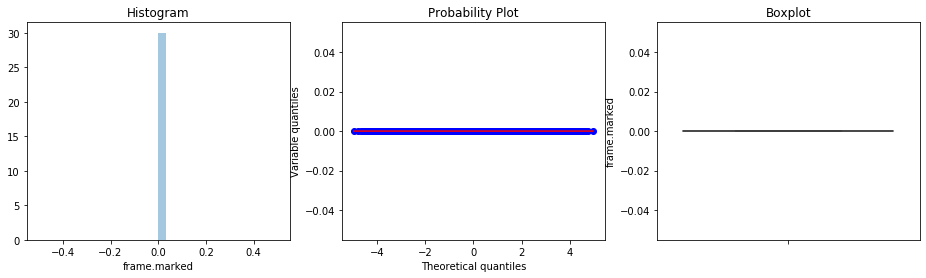

Feature: frame.ignored

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: frame.ignored, dtype: float64
 


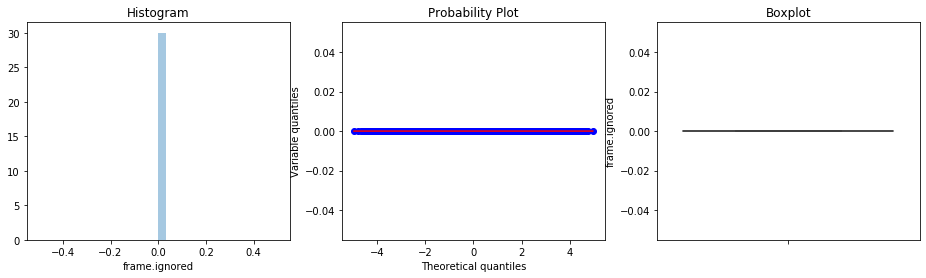

Feature: radiotap.version

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.version, dtype: float64
 


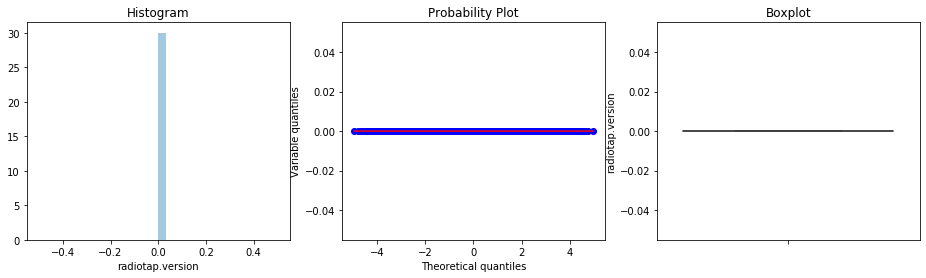

Feature: radiotap.pad

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.pad, dtype: float64
 


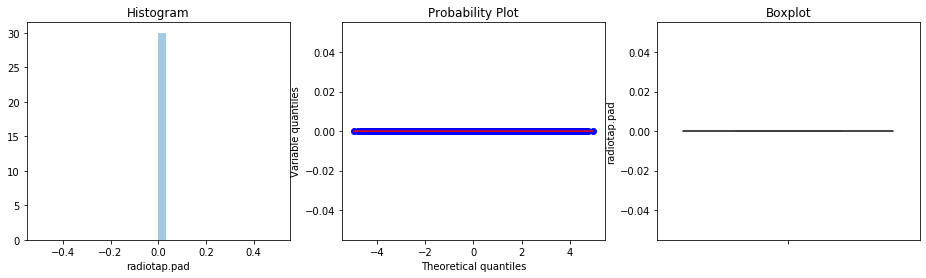

Feature: radiotap.length

count    1.795574e+06
mean     2.599435e+01
std      2.708911e-01
min      1.300000e+01
25%      2.600000e+01
50%      2.600000e+01
75%      2.600000e+01
max      2.600000e+01
Name: radiotap.length, dtype: float64
 


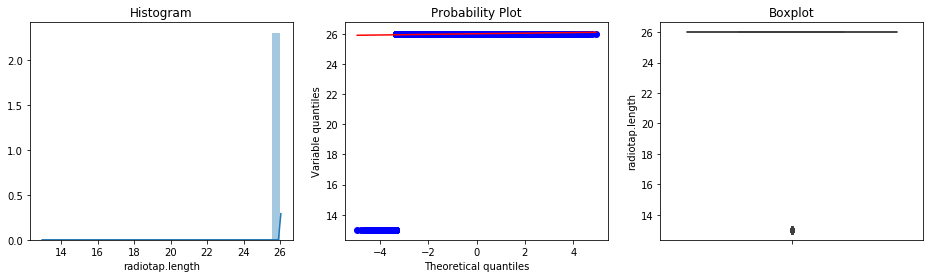

Feature: radiotap.present.tsft

count    1.795574e+06
mean     9.995656e-01
std      2.083778e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: radiotap.present.tsft, dtype: float64
 


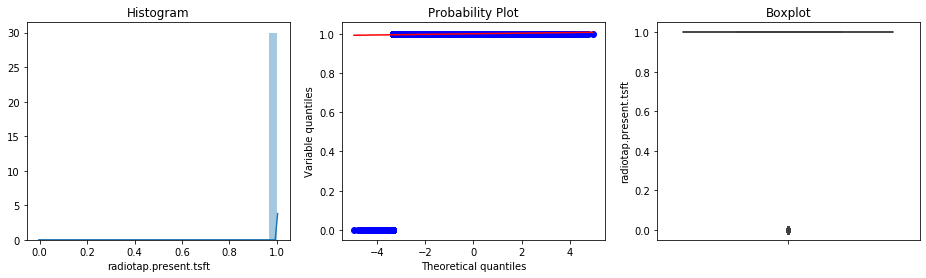

Feature: radiotap.present.flags

count    1.795574e+06
mean     9.995656e-01
std      2.083778e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: radiotap.present.flags, dtype: float64
 


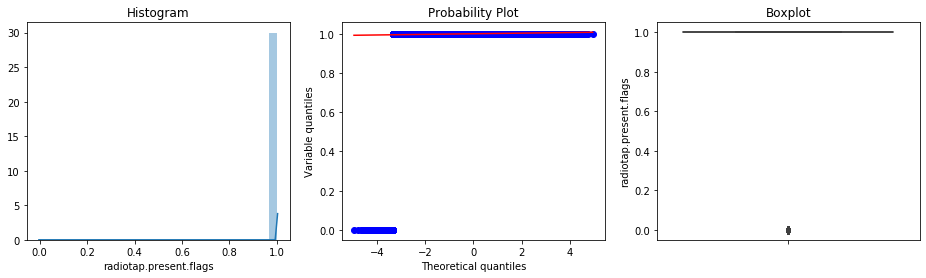

Feature: radiotap.present.rate

count    1795574.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: radiotap.present.rate, dtype: float64
 


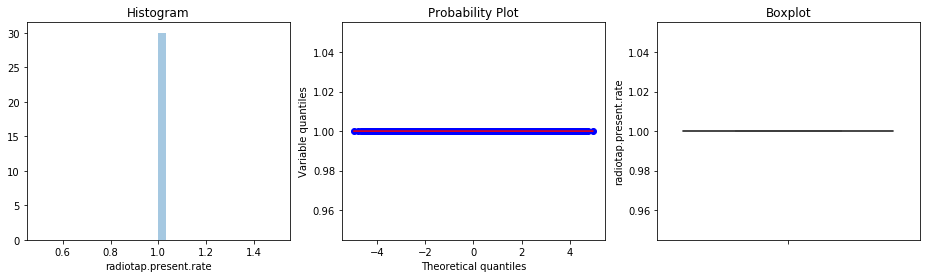

Feature: radiotap.present.channel

count    1.795574e+06
mean     9.995656e-01
std      2.083778e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: radiotap.present.channel, dtype: float64
 


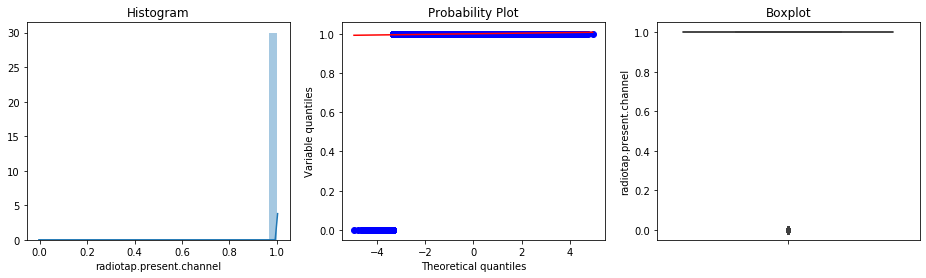

Feature: radiotap.present.fhss

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.fhss, dtype: float64
 


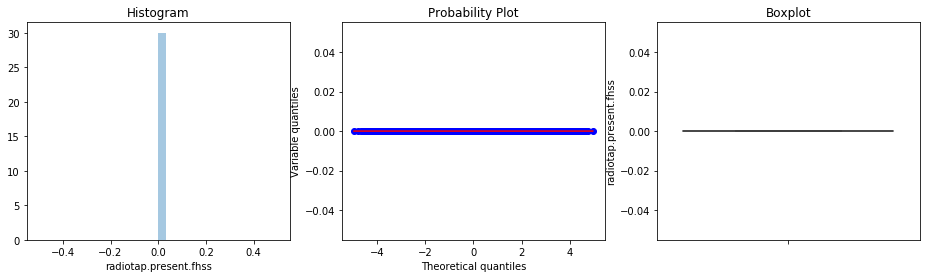

Feature: radiotap.present.dbm_antsignal

count    1.795574e+06
mean     9.995656e-01
std      2.083778e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: radiotap.present.dbm_antsignal, dtype: float64
 


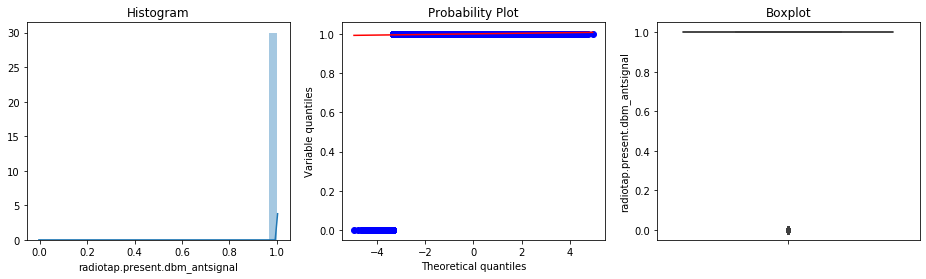

Feature: radiotap.present.dbm_antnoise

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.dbm_antnoise, dtype: float64
 


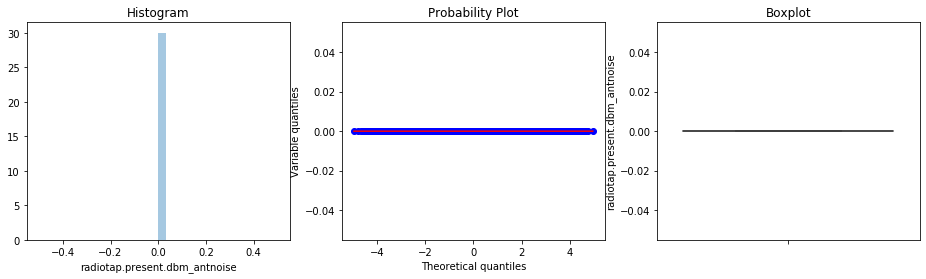

Feature: radiotap.present.lock_quality

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.lock_quality, dtype: float64
 


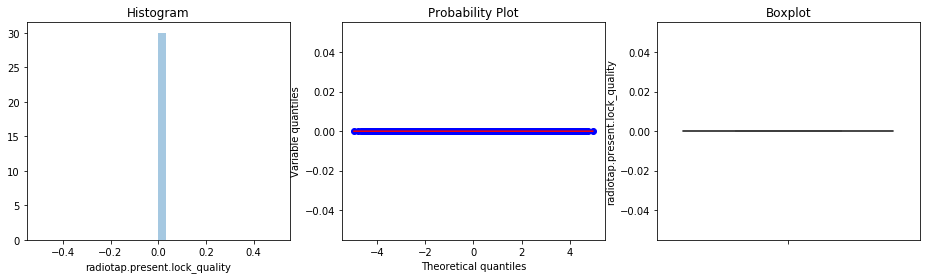

Feature: radiotap.present.tx_attenuation

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.tx_attenuation, dtype: float64
 


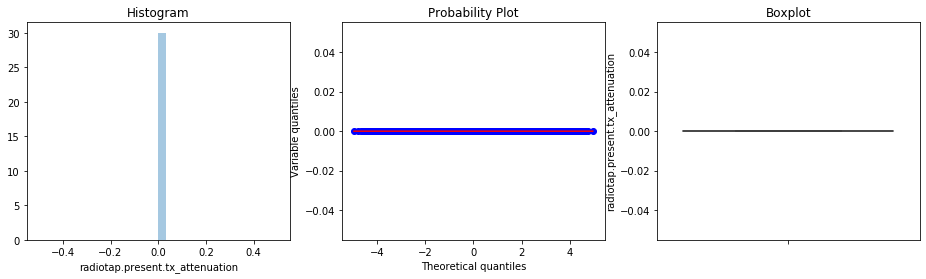

Feature: radiotap.present.db_tx_attenuation

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.db_tx_attenuation, dtype: float64
 


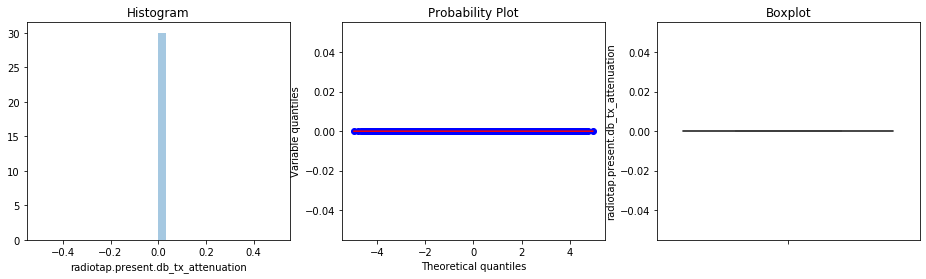

Feature: radiotap.present.dbm_tx_power

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.dbm_tx_power, dtype: float64
 


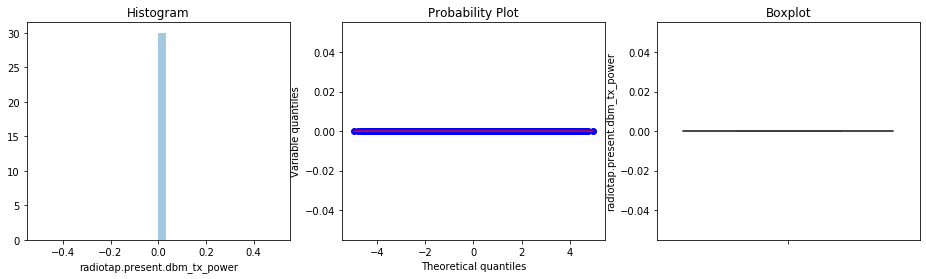

Feature: radiotap.present.antenna

count    1.795574e+06
mean     9.995656e-01
std      2.083778e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: radiotap.present.antenna, dtype: float64
 


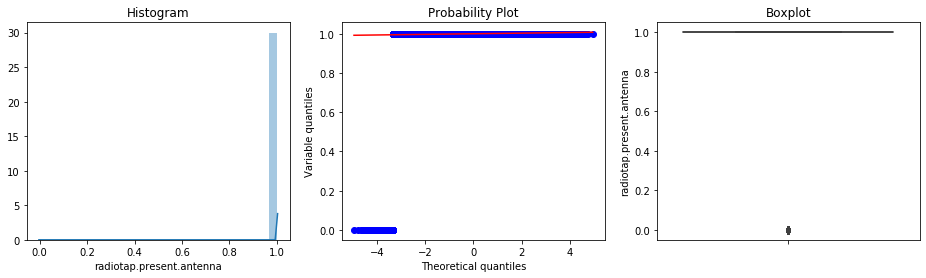

Feature: radiotap.present.db_antsignal

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.db_antsignal, dtype: float64
 


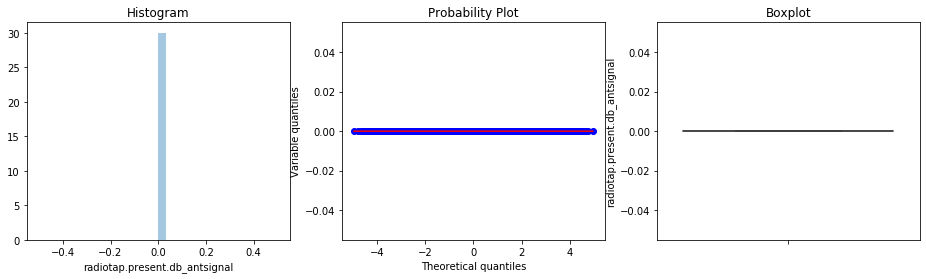

Feature: radiotap.present.db_antnoise

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.db_antnoise, dtype: float64
 


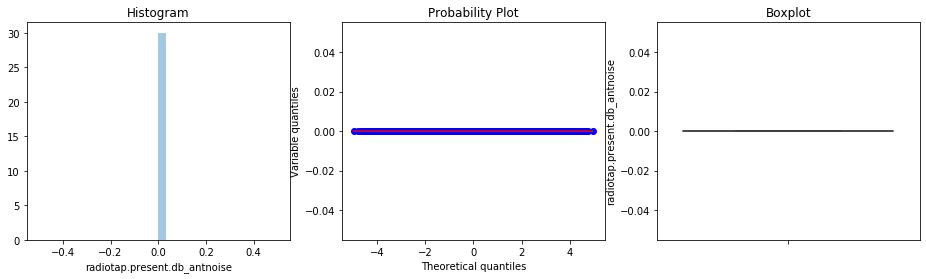

Feature: radiotap.present.rxflags

count    1.795574e+06
mean     9.995656e-01
std      2.083778e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: radiotap.present.rxflags, dtype: float64
 


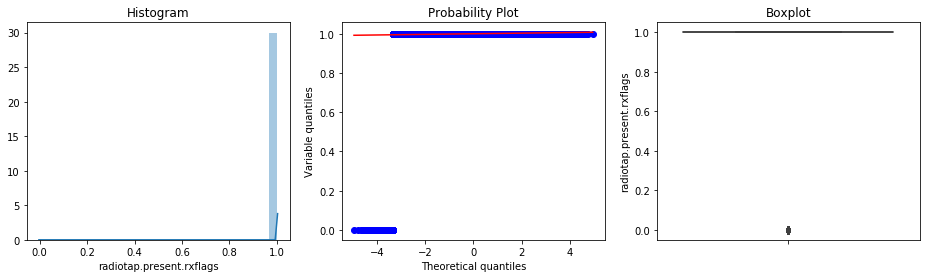

Feature: radiotap.present.xchannel

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.xchannel, dtype: float64
 


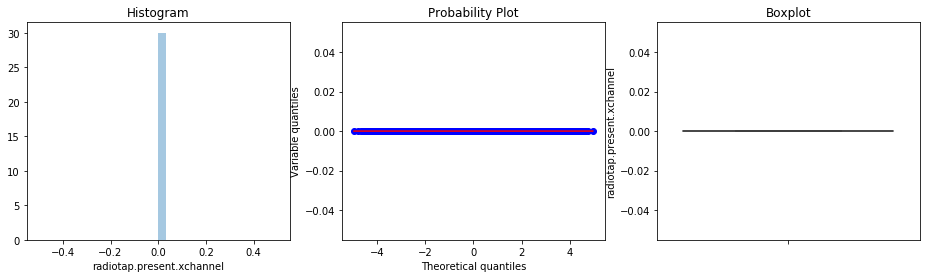

Feature: radiotap.present.mcs

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.mcs, dtype: float64
 


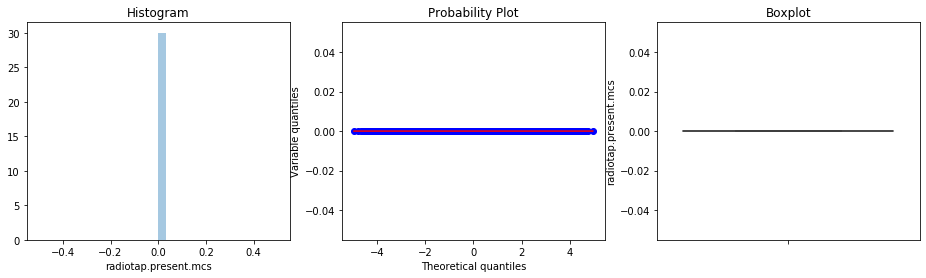

Feature: radiotap.present.ampdu

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.ampdu, dtype: float64
 


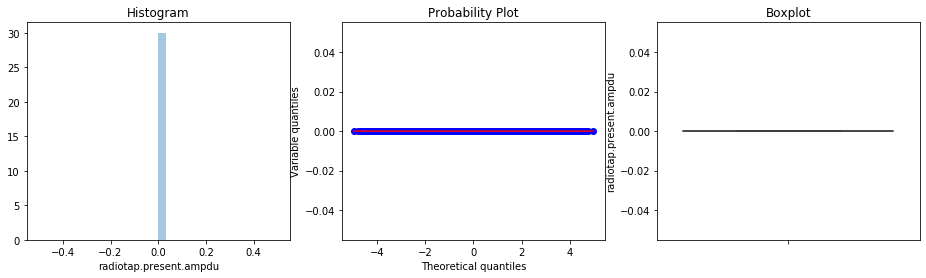

Feature: radiotap.present.vht

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.vht, dtype: float64
 


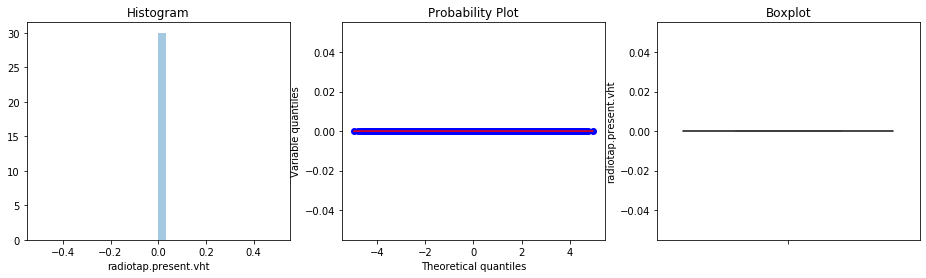

Feature: radiotap.present.rtap_ns

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.rtap_ns, dtype: float64
 


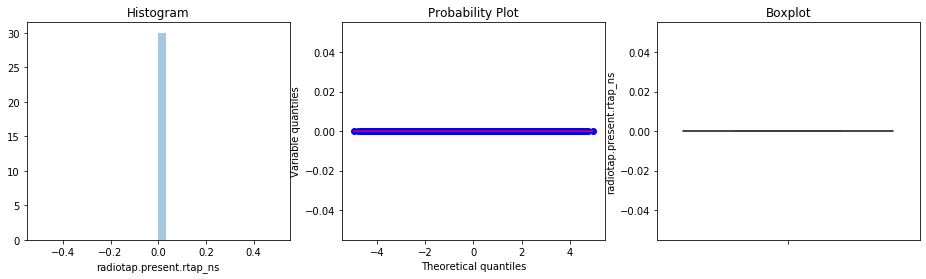

Feature: radiotap.present.vendor_ns

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.vendor_ns, dtype: float64
 


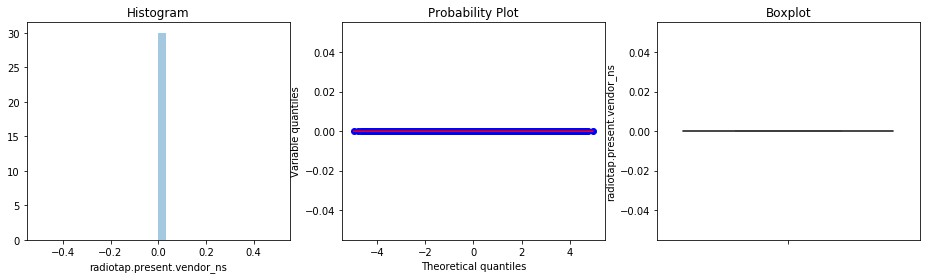

Feature: radiotap.present.ext

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.present.ext, dtype: float64
 


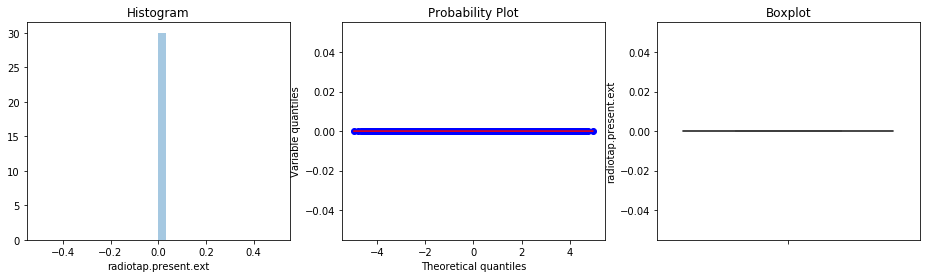

Feature: radiotap.mactime

count    1.794794e+06
mean     3.971911e+09
std      8.673517e+08
min      2.101623e+09
25%      3.129488e+09
50%      4.004209e+09
75%      4.625640e+09
max      5.701134e+09
Name: radiotap.mactime, dtype: float64
 


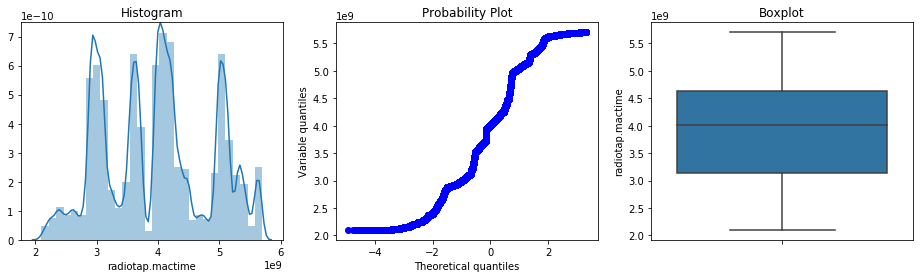

Feature: radiotap.flags.cfp

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.flags.cfp, dtype: float64
 


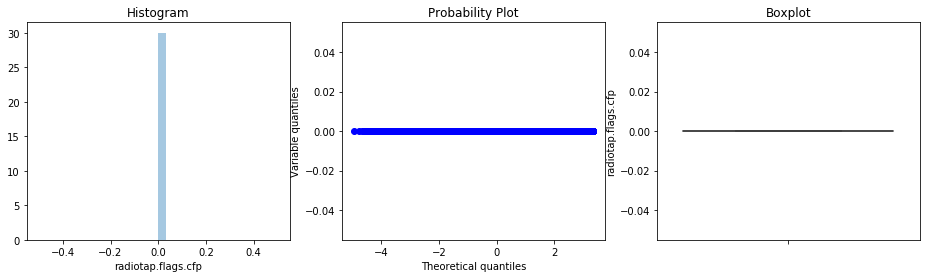

Feature: radiotap.flags.preamble

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.flags.preamble, dtype: float64
 


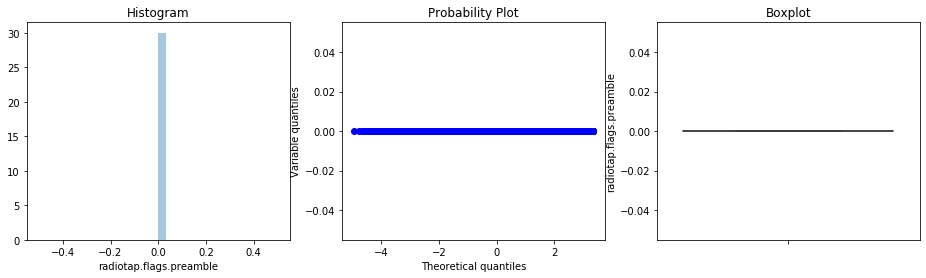

Feature: radiotap.flags.wep

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.flags.wep, dtype: float64
 


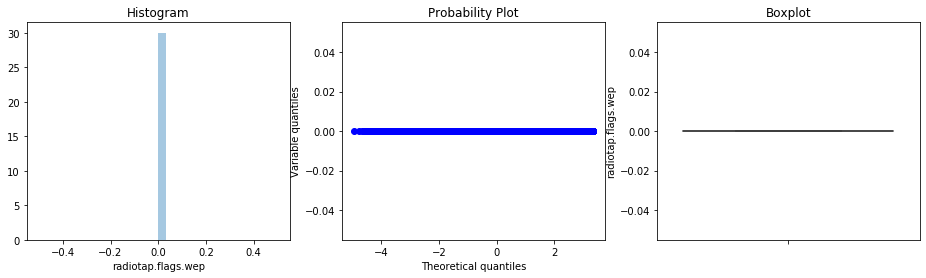

Feature: radiotap.flags.frag

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.flags.frag, dtype: float64
 


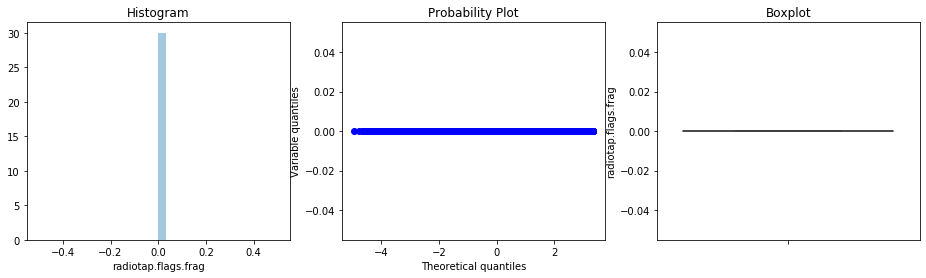

Feature: radiotap.flags.fcs

count    1794794.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: radiotap.flags.fcs, dtype: float64
 


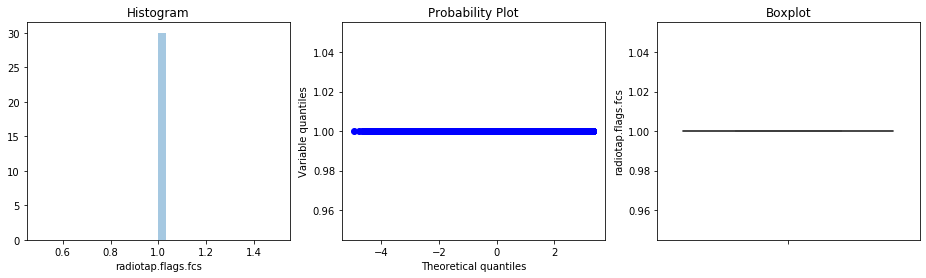

Feature: radiotap.flags.datapad

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.flags.datapad, dtype: float64
 


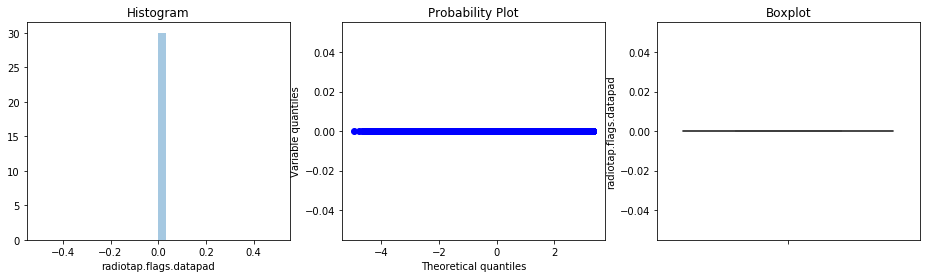

Feature: radiotap.flags.badfcs

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.flags.badfcs, dtype: float64
 


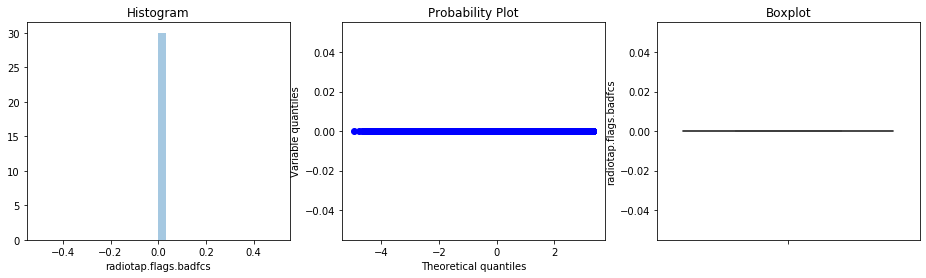

Feature: radiotap.flags.shortgi

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.flags.shortgi, dtype: float64
 


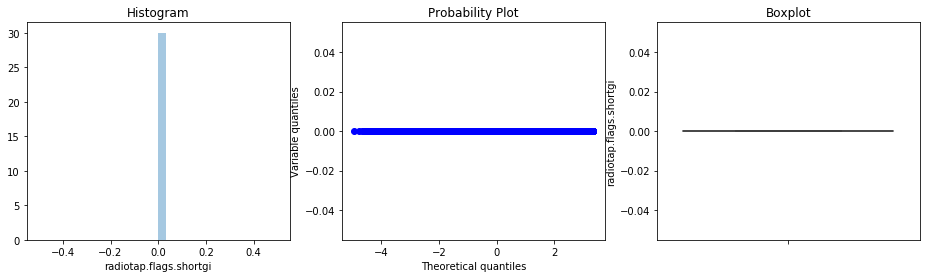

Feature: radiotap.datarate

count    1.795574e+06
mean     2.513951e+01
std      2.373590e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.400000e+01
75%      5.400000e+01
max      5.400000e+01
Name: radiotap.datarate, dtype: float64
 


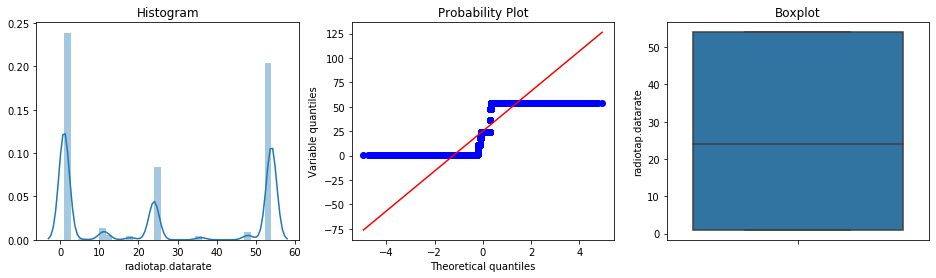

Feature: radiotap.channel.freq

count    1.794794e+06
mean     2.437006e+03
std      6.110732e-01
min      2.412000e+03
25%      2.437000e+03
50%      2.437000e+03
75%      2.437000e+03
max      2.484000e+03
Name: radiotap.channel.freq, dtype: float64
 


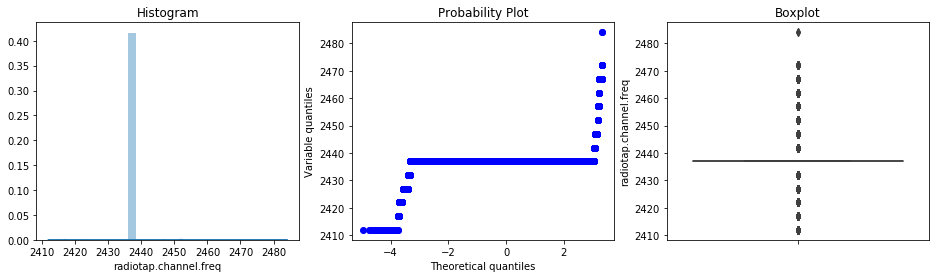

Feature: radiotap.channel.type.turbo

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.turbo, dtype: float64
 


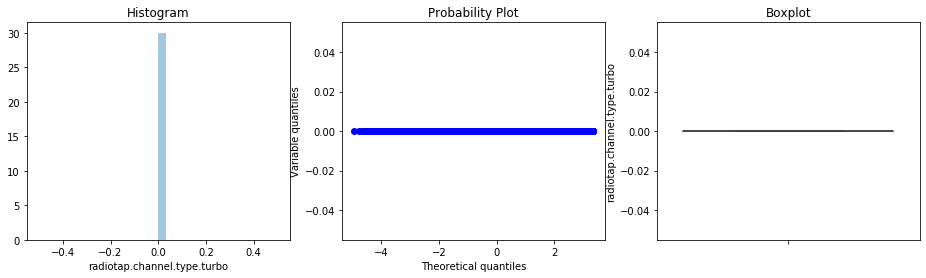

Feature: radiotap.channel.type.cck

count    1.794794e+06
mean     4.473054e-01
std      4.972157e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: radiotap.channel.type.cck, dtype: float64
 


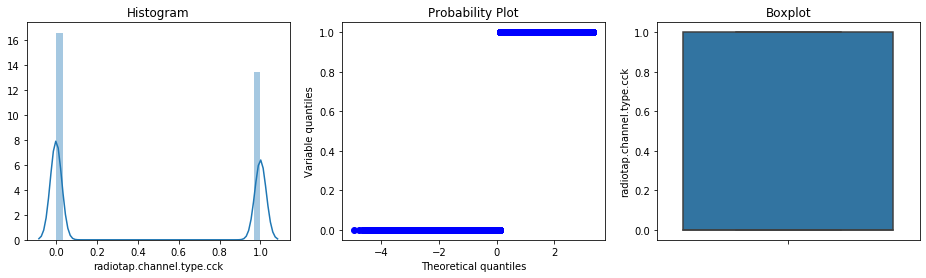

Feature: radiotap.channel.type.ofdm

count    1.794794e+06
mean     5.526946e-01
std      4.972157e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: radiotap.channel.type.ofdm, dtype: float64
 


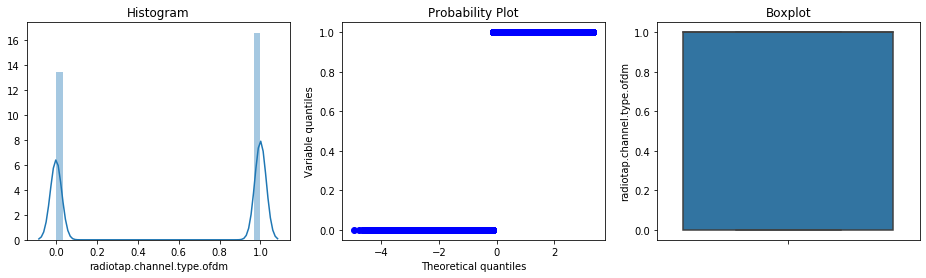

Feature: radiotap.channel.type.2ghz

count    1794794.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: radiotap.channel.type.2ghz, dtype: float64
 


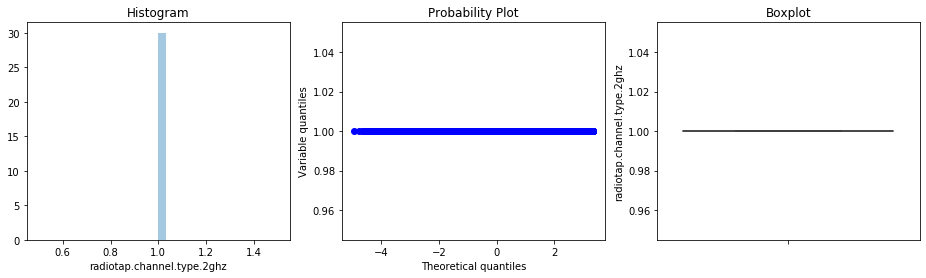

Feature: radiotap.channel.type.5ghz

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.5ghz, dtype: float64
 


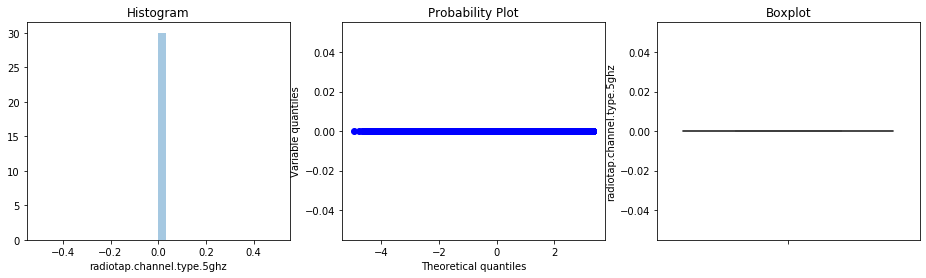

Feature: radiotap.channel.type.passive

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.passive, dtype: float64
 


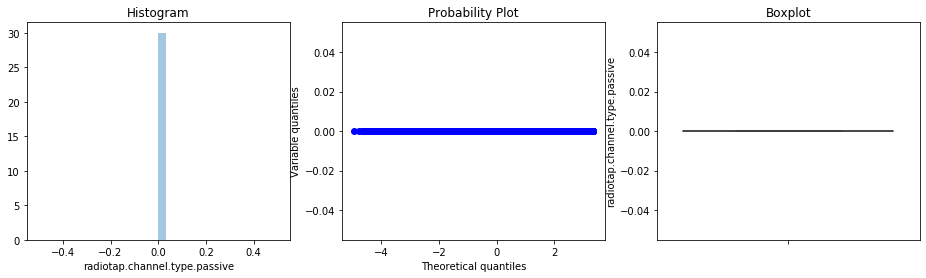

Feature: radiotap.channel.type.dynamic

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.dynamic, dtype: float64
 


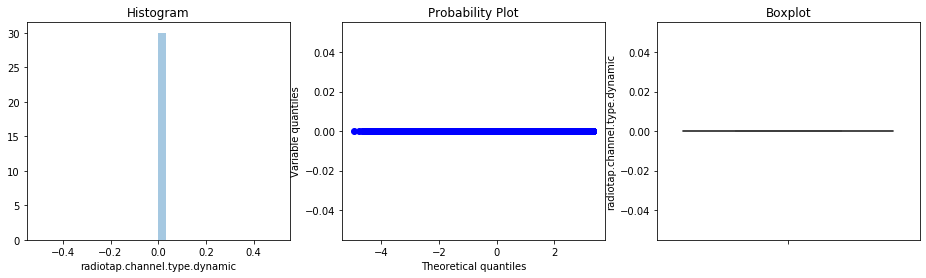

Feature: radiotap.channel.type.gfsk

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.gfsk, dtype: float64
 


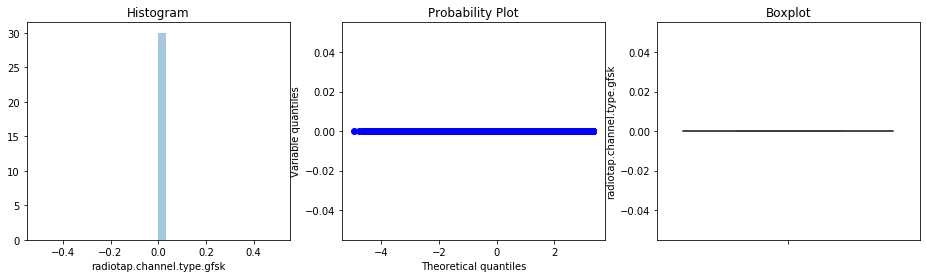

Feature: radiotap.channel.type.gsm

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.gsm, dtype: float64
 


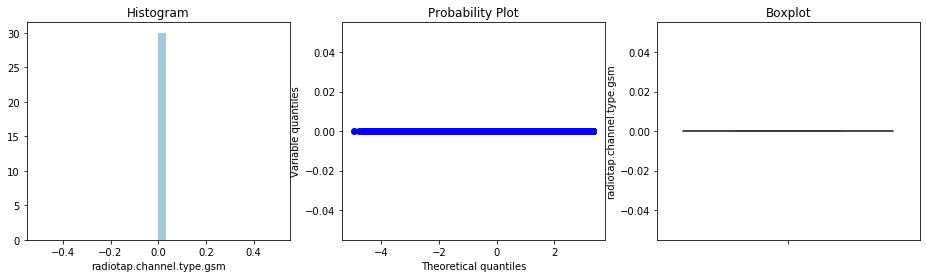

Feature: radiotap.channel.type.sturbo

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.sturbo, dtype: float64
 


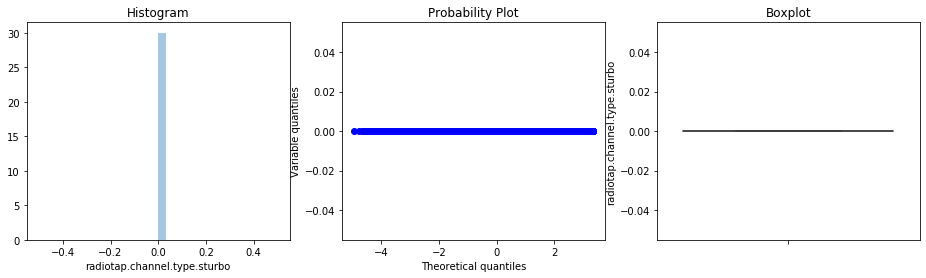

Feature: radiotap.channel.type.half

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.half, dtype: float64
 


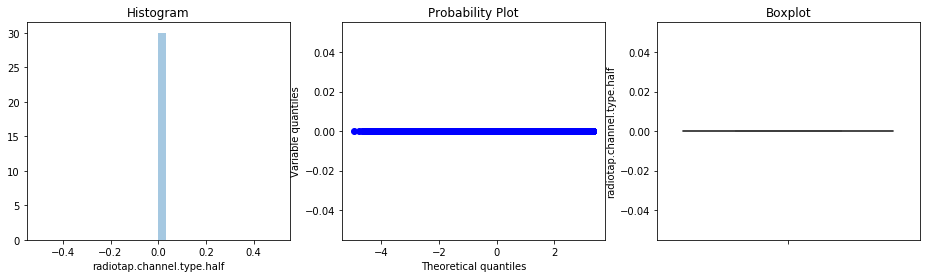

Feature: radiotap.channel.type.quarter

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.channel.type.quarter, dtype: float64
 


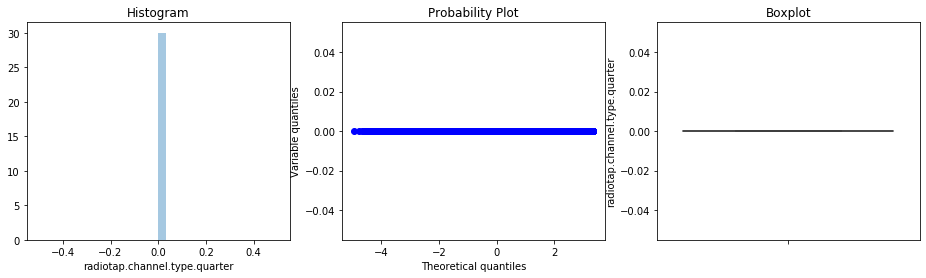

Feature: radiotap.dbm_antsignal

count    1.794794e+06
mean    -2.810740e+01
std      1.022951e+01
min     -7.100000e+01
25%     -3.000000e+01
50%     -2.500000e+01
75%     -2.100000e+01
max     -6.000000e+00
Name: radiotap.dbm_antsignal, dtype: float64
 


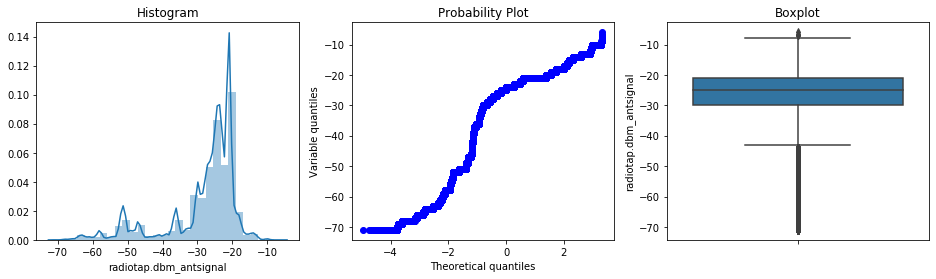

Feature: radiotap.antenna

count    1794794.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: radiotap.antenna, dtype: float64
 


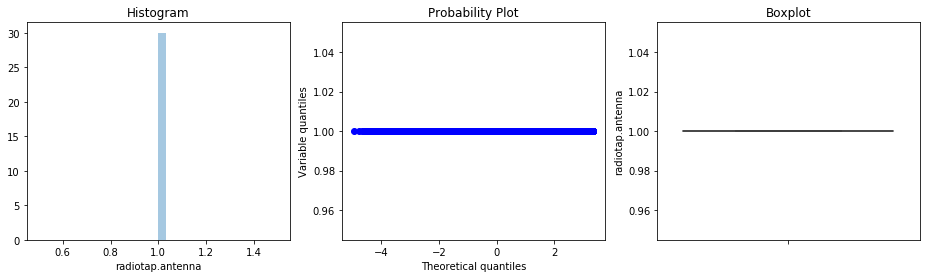

Feature: radiotap.rxflags.badplcp

count    1794794.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: radiotap.rxflags.badplcp, dtype: float64
 


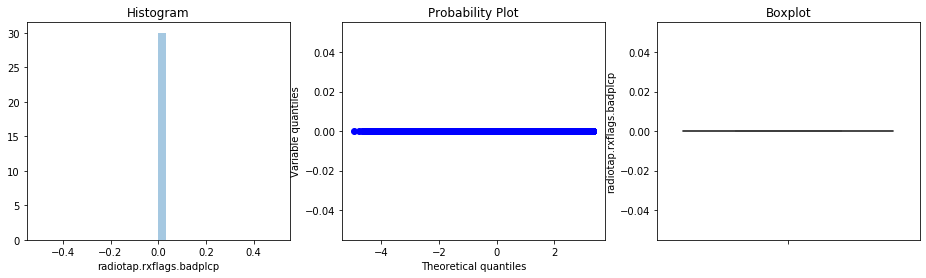

Feature: wlan.fc.version

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: wlan.fc.version, dtype: float64
 


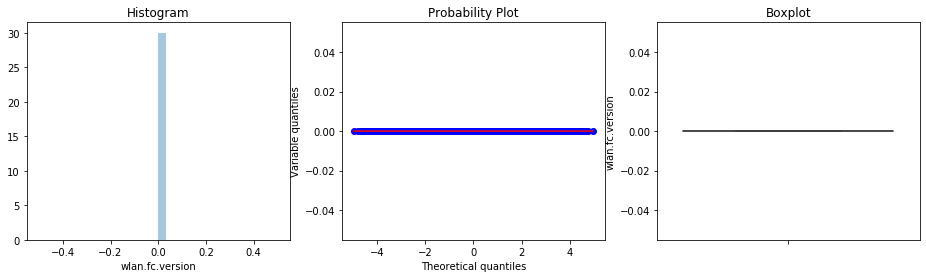

Feature: wlan.fc.type

count    1.795574e+06
mean     1.272583e+00
std      8.198057e-01
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: wlan.fc.type, dtype: float64
 


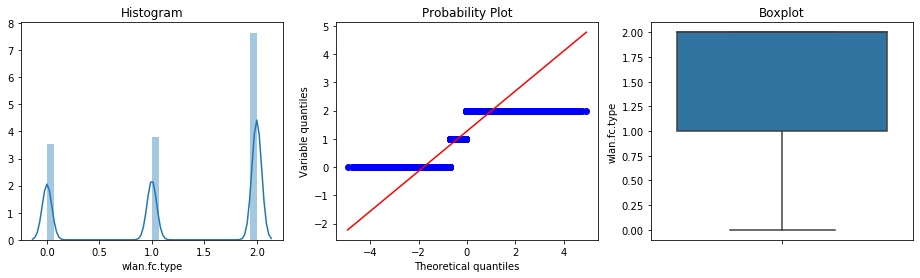

Feature: wlan.fc.subtype

count    1.795574e+06
mean     8.499055e+00
std      4.173016e+00
min      0.000000e+00
25%      8.000000e+00
50%      8.000000e+00
75%      1.200000e+01
max      1.300000e+01
Name: wlan.fc.subtype, dtype: float64
 


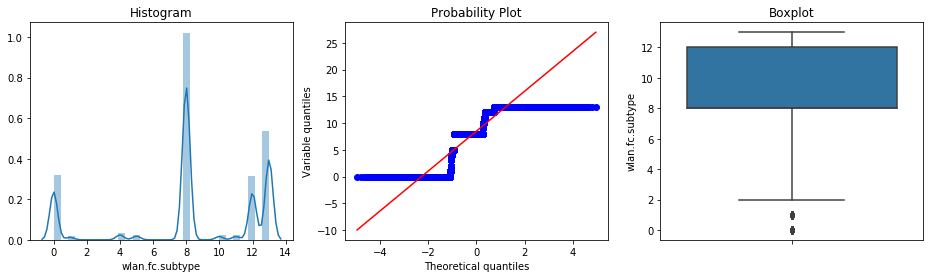

Feature: wlan.fc.frag

count    1.795574e+06
mean     3.748105e-04
std      1.935640e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: wlan.fc.frag, dtype: float64
 


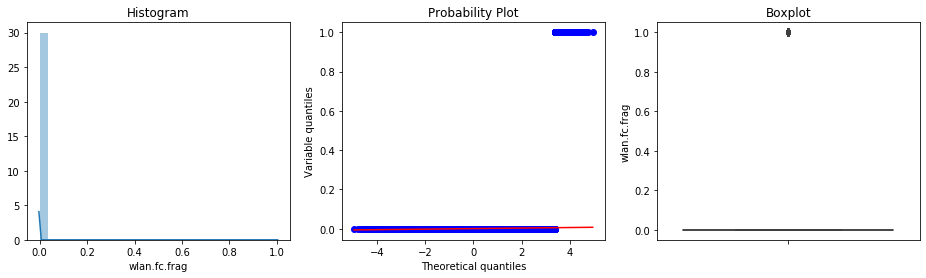

Feature: wlan.fc.retry

count    1.795574e+06
mean     1.271081e-01
std      3.330941e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: wlan.fc.retry, dtype: float64
 


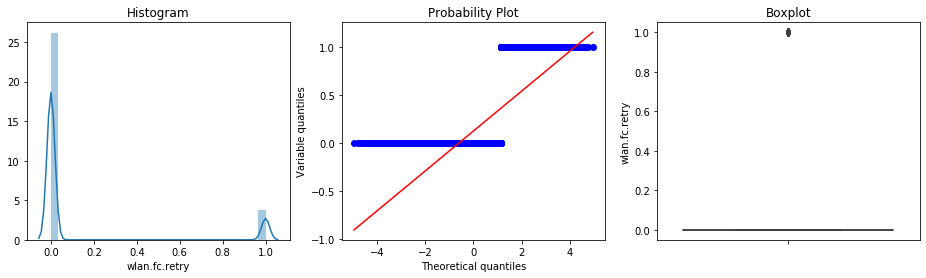

Feature: wlan.fc.pwrmgt

count    1.795574e+06
mean     2.325217e-02
std      1.507034e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: wlan.fc.pwrmgt, dtype: float64
 


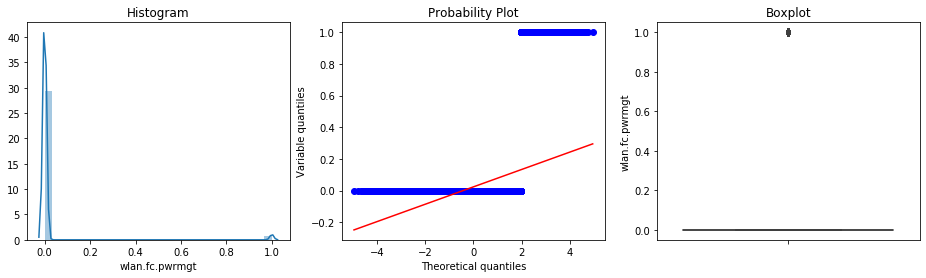

Feature: wlan.fc.moredata

count    1.795574e+06
mean     1.772692e-03
std      4.206603e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: wlan.fc.moredata, dtype: float64
 


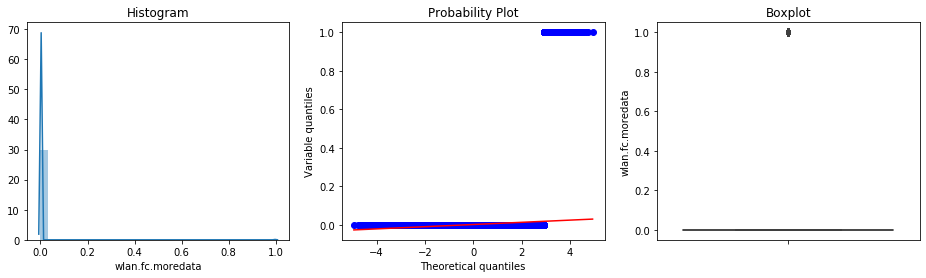

Feature: wlan.fc.protected

count    1.795574e+06
mean     4.932930e-01
std      4.999552e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: wlan.fc.protected, dtype: float64
 


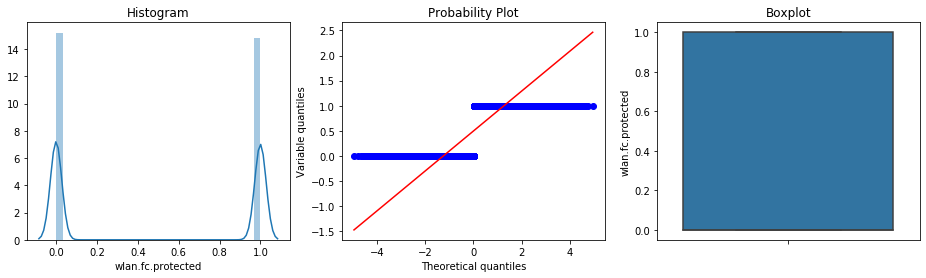

Feature: wlan.fc.order

count    1795574.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: wlan.fc.order, dtype: float64
 


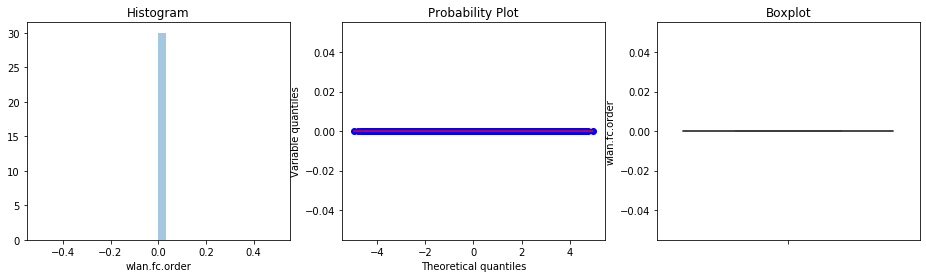

Feature: wlan.duration

count    1.794382e+06
mean     8.402897e+01
std      1.731928e+02
min      0.000000e+00
25%      0.000000e+00
50%      4.400000e+01
75%      4.400000e+01
max      1.450000e+04
Name: wlan.duration, dtype: float64
 


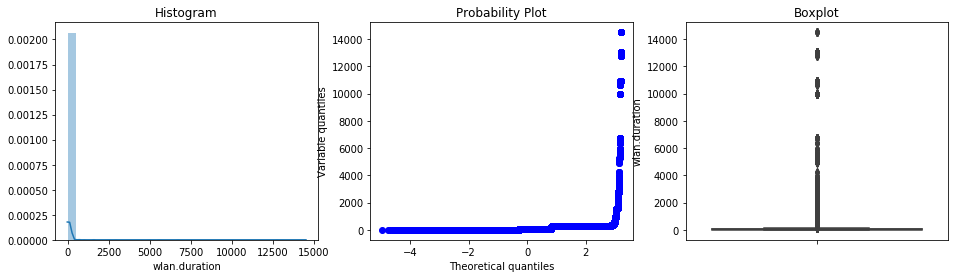

Feature: wlan.frag

count    1.340185e+06
mean     2.164627e-03
std      1.176390e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.200000e+01
Name: wlan.frag, dtype: float64
 


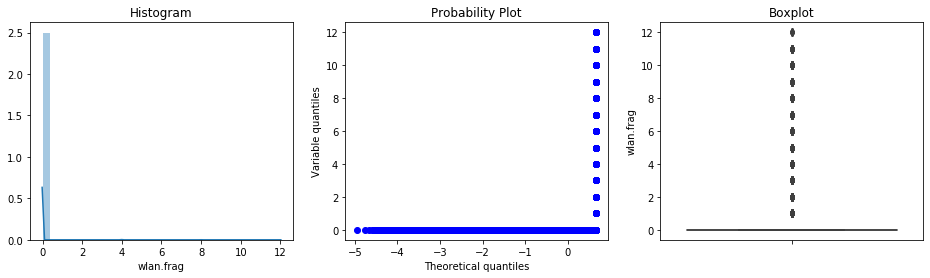

Feature: wlan.seq

count    1.340185e+06
mean     1.910166e+03
std      1.200124e+03
min      0.000000e+00
25%      8.400000e+02
50%      1.811000e+03
75%      2.940000e+03
max      4.095000e+03
Name: wlan.seq, dtype: float64
 


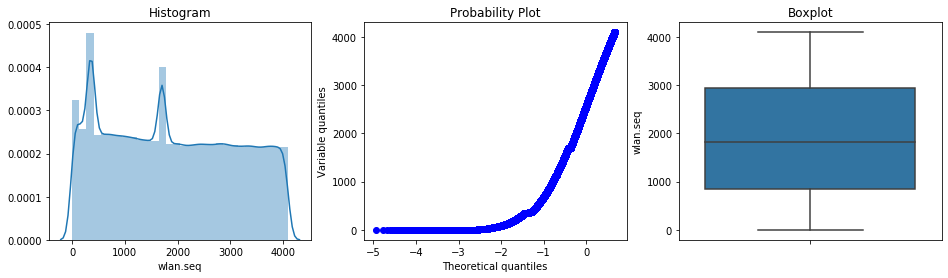

Feature: wlan.ba.control.ackpolicy

count    101.000000
mean       0.752475
std        0.433727
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: wlan.ba.control.ackpolicy, dtype: float64
 


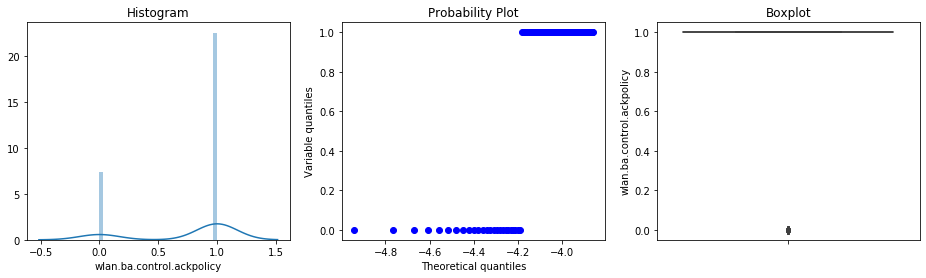

Feature: wlan.ba.control.multitid

count    101.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: wlan.ba.control.multitid, dtype: float64
 


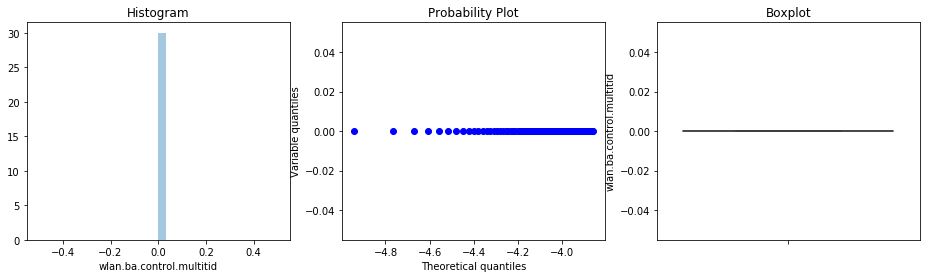

Feature: wlan.ba.control.cbitmap

count    101.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: wlan.ba.control.cbitmap, dtype: float64
 


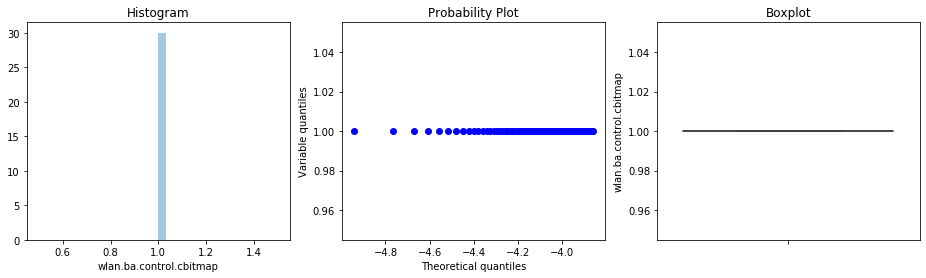

Feature: wlan.fcs_good

count    1794794.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: wlan.fcs_good, dtype: float64
 


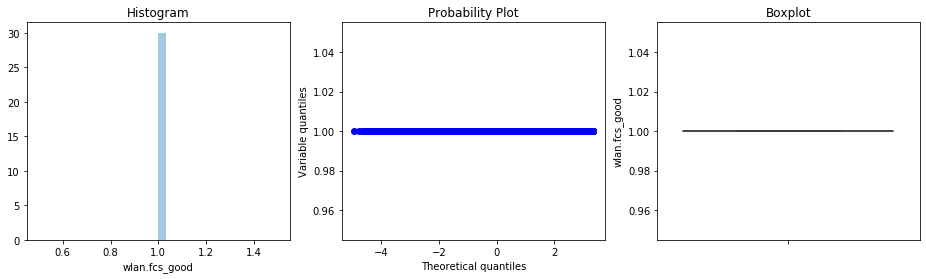

Feature: wlan_mgt.fixed.capabilities.ess

count    180749.00000
mean          0.99558
std           0.06634
min           0.00000
25%           1.00000
50%           1.00000
75%           1.00000
max           1.00000
Name: wlan_mgt.fixed.capabilities.ess, dtype: float64
 


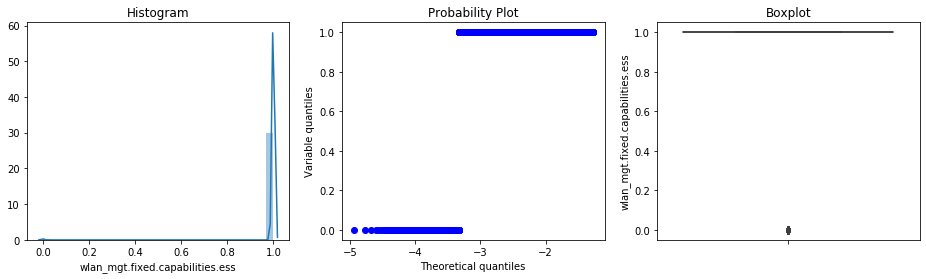

Feature: wlan_mgt.fixed.capabilities.ibss

count    180749.000000
mean          0.004271
std           0.065214
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.ibss, dtype: float64
 


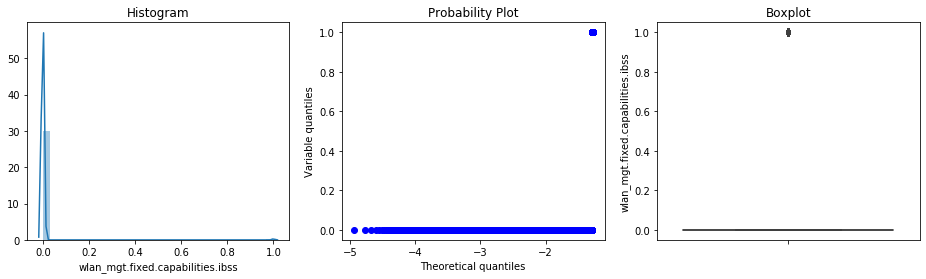

Feature: wlan_mgt.fixed.capabilities.privacy

count    180749.000000
mean          0.677188
std           0.467553
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.privacy, dtype: float64
 


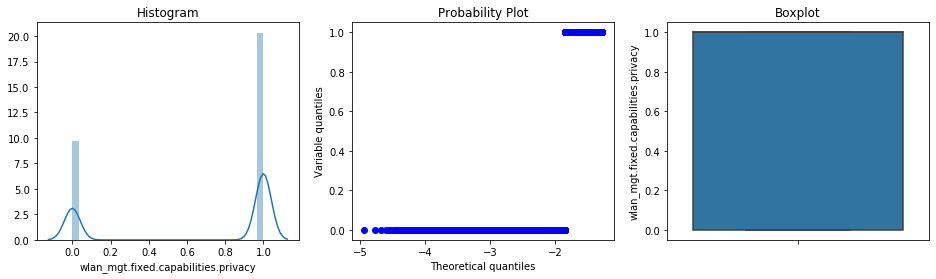

Feature: wlan_mgt.fixed.capabilities.preamble

count    180749.000000
mean          0.549115
std           0.497583
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.preamble, dtype: float64
 


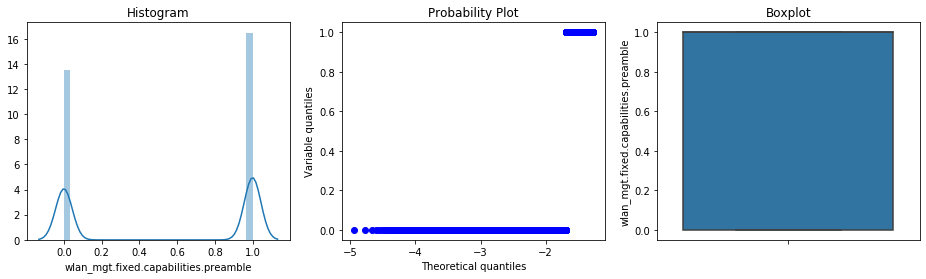

Feature: wlan_mgt.fixed.capabilities.pbcc

count    180749.000000
mean          0.004282
std           0.065298
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.pbcc, dtype: float64
 


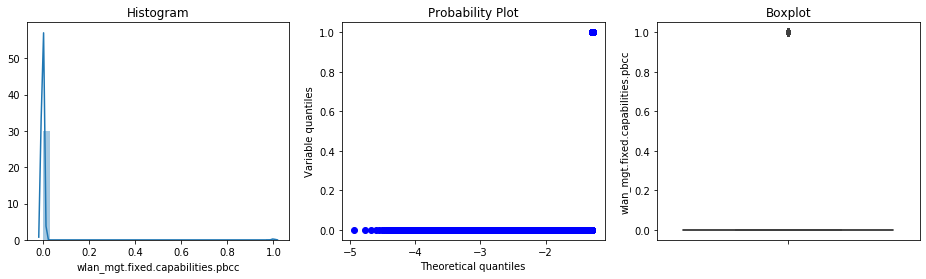

Feature: wlan_mgt.fixed.capabilities.agility

count    180749.000000
mean          0.004376
std           0.066008
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.agility, dtype: float64
 


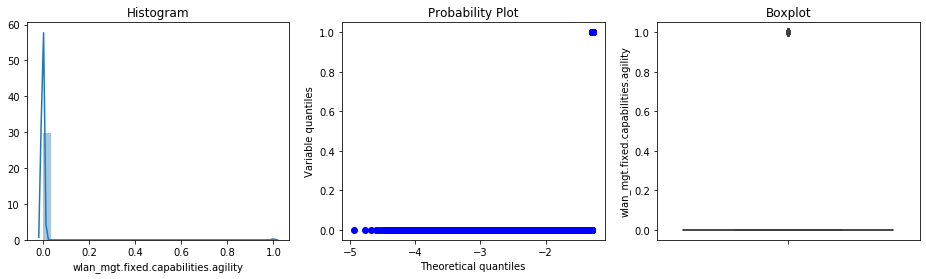

Feature: wlan_mgt.fixed.capabilities.spec_man

count    180749.000000
mean          0.004470
std           0.066711
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.spec_man, dtype: float64
 


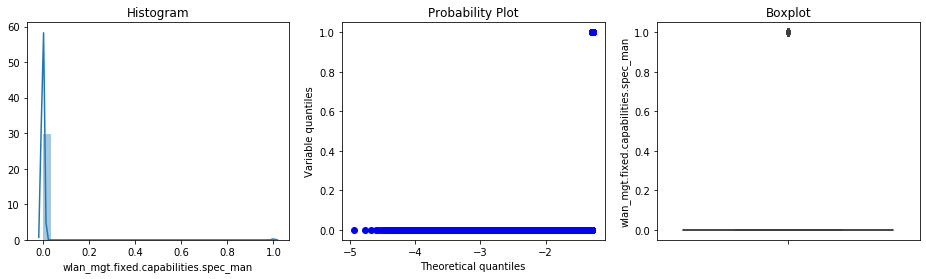

Feature: wlan_mgt.fixed.capabilities.short_slot_time

count    180749.000000
mean          0.962357
std           0.190333
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.short_slot_time, dtype: float64
 


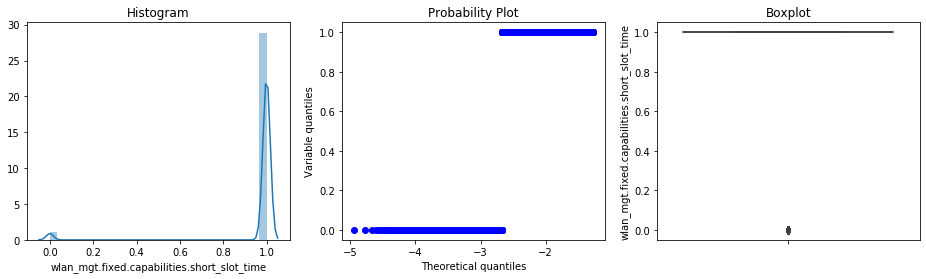

Feature: wlan_mgt.fixed.capabilities.apsd

count    180749.000000
mean          0.004487
std           0.066834
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.apsd, dtype: float64
 


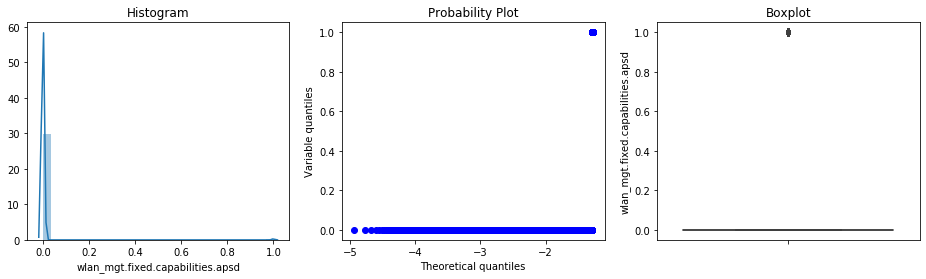

Feature: wlan_mgt.fixed.capabilities.radio_measurement

count    180749.000000
mean          0.004454
std           0.066587
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.radio_measurement, dtype: float64
 


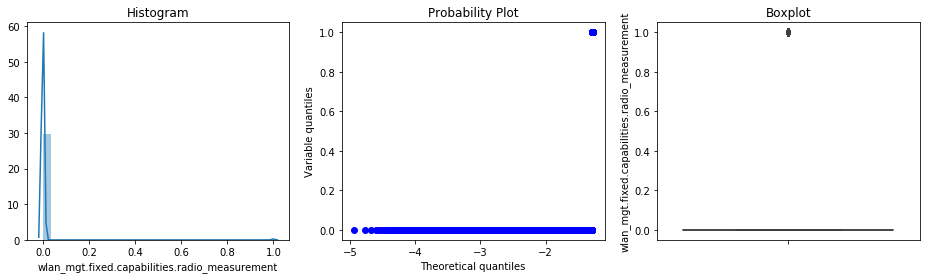

Feature: wlan_mgt.fixed.capabilities.dsss_ofdm

count    180749.000000
mean          0.004271
std           0.065214
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.dsss_ofdm, dtype: float64
 


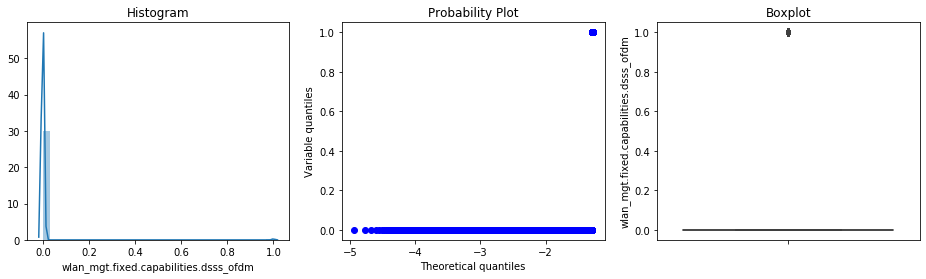

Feature: wlan_mgt.fixed.capabilities.del_blk_ack

count    180749.000000
mean          0.004293
std           0.065382
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.del_blk_ack, dtype: float64
 


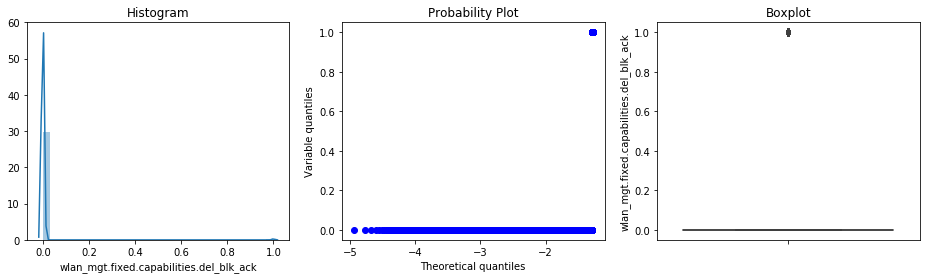

Feature: wlan_mgt.fixed.capabilities.imm_blk_ack

count    180749.000000
mean          0.004266
std           0.065172
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.fixed.capabilities.imm_blk_ack, dtype: float64
 


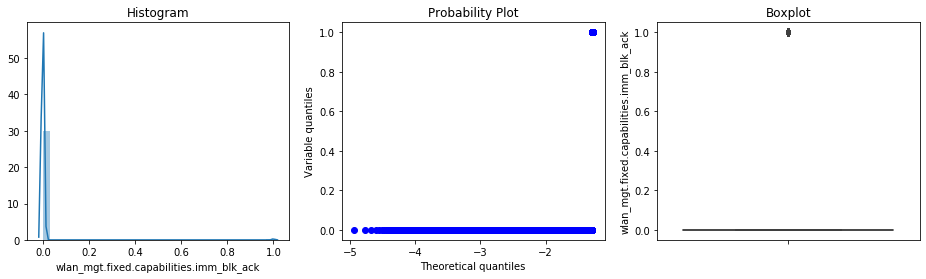

Feature: wlan_mgt.fixed.beacon

count    152092.000000
mean        435.153401
std        3802.135743
min          20.000000
25%         100.000000
50%         100.000000
75%         100.000000
max       65357.000000
Name: wlan_mgt.fixed.beacon, dtype: float64
 


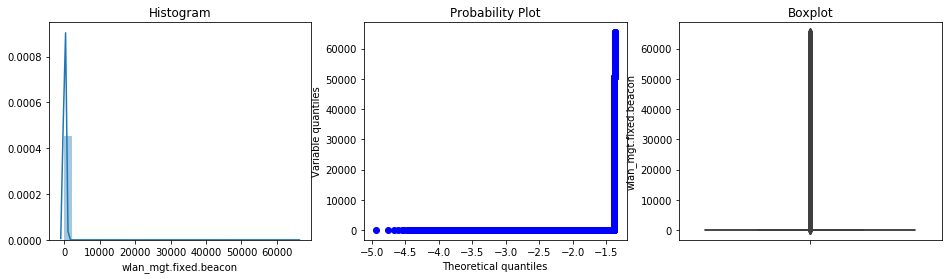

Feature: wlan_mgt.fixed.auth.alg

count    15861.000000
mean         0.028182
std          0.165499
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: wlan_mgt.fixed.auth.alg, dtype: float64
 


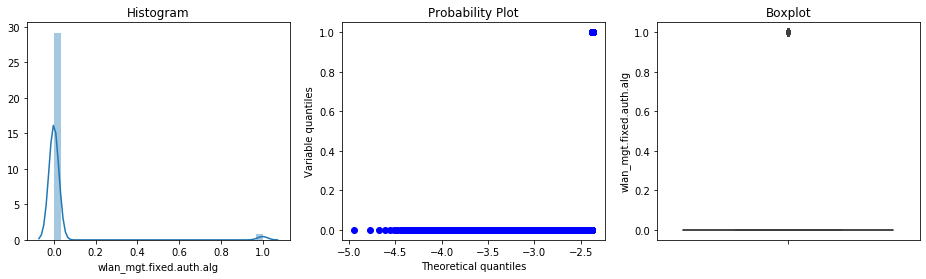

Feature: wlan_mgt.fixed.category_code

count    28.000000
mean      5.571429
std       1.951800
min       3.000000
25%       3.000000
50%       7.000000
75%       7.000000
max       7.000000
Name: wlan_mgt.fixed.category_code, dtype: float64
 


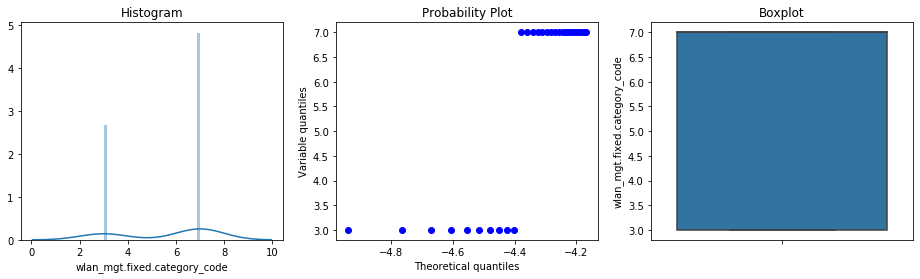

Feature: wlan_mgt.fixed.fragment

count    103.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: wlan_mgt.fixed.fragment, dtype: float64
 


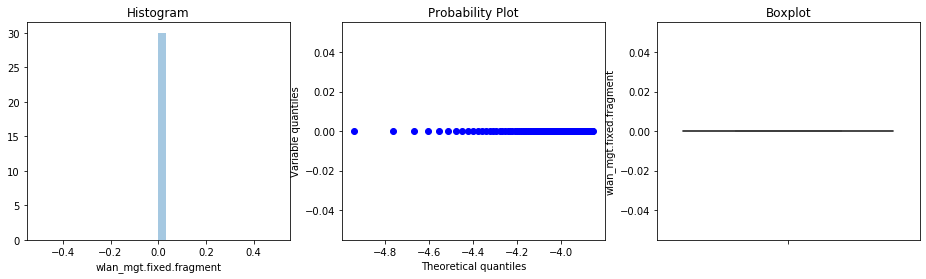

Feature: wlan_mgt.fixed.sequence

count     103.000000
mean      178.699029
std       273.605084
min         0.000000
25%         9.000000
50%       129.000000
75%       253.500000
max      2620.000000
Name: wlan_mgt.fixed.sequence, dtype: float64
 


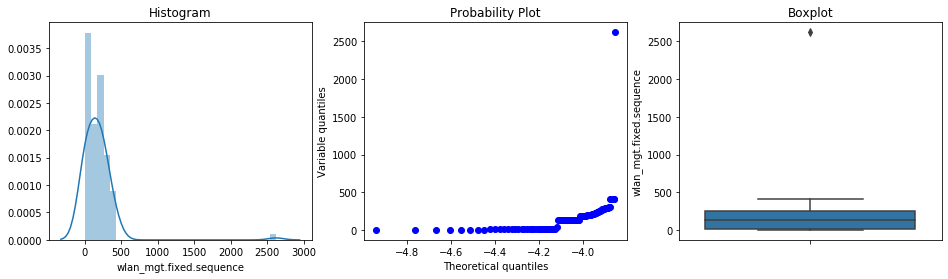

Feature: wlan_mgt.tagged.all

count    190501.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: wlan_mgt.tagged.all, dtype: float64
 


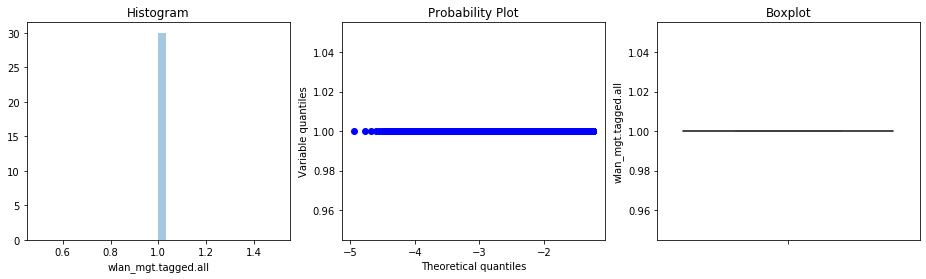

Feature: wlan_mgt.ds.current_channel

count    156851.000000
mean          6.008741
std           0.456351
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max          13.000000
Name: wlan_mgt.ds.current_channel, dtype: float64
 


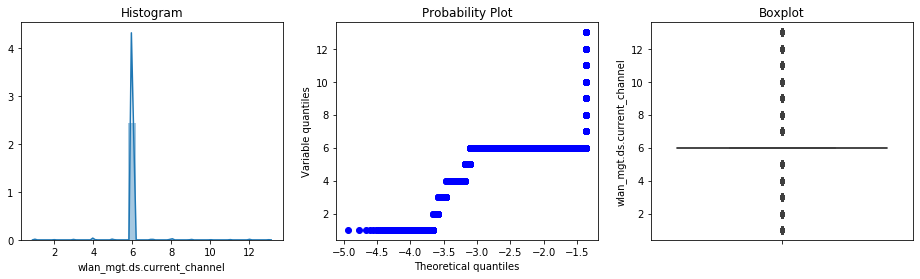

Feature: wlan_mgt.tim.dtim_count

count    129894.000000
mean          0.161593
std           2.061838
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         219.000000
Name: wlan_mgt.tim.dtim_count, dtype: float64
 


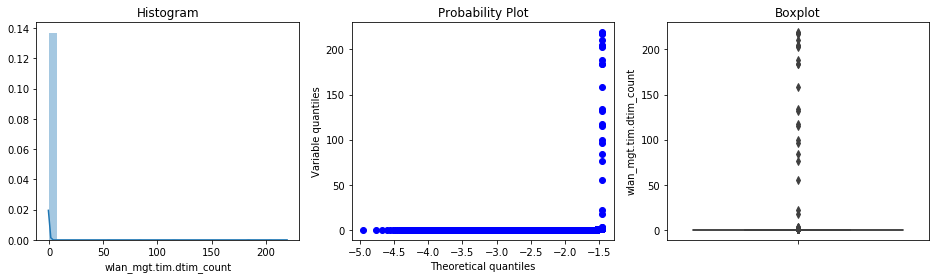

Feature: wlan_mgt.tim.dtim_period

count    129894.000000
mean          1.289474
std           2.296232
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         252.000000
Name: wlan_mgt.tim.dtim_period, dtype: float64
 


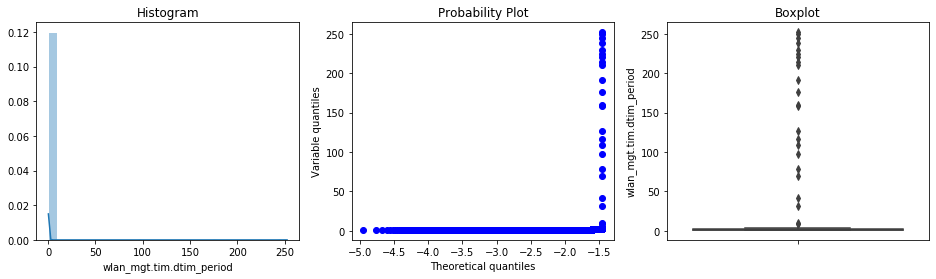

Feature: wlan_mgt.tim.bmapctl.multicast

count    129894.000000
mean          0.013757
std           0.116483
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wlan_mgt.tim.bmapctl.multicast, dtype: float64
 


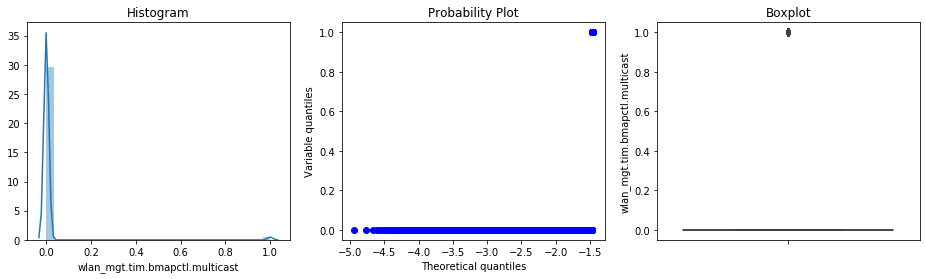

Feature: wlan_mgt.rsn.version

count    76944.000000
mean         9.047788
std        584.911157
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      65138.000000
Name: wlan_mgt.rsn.version, dtype: float64
 


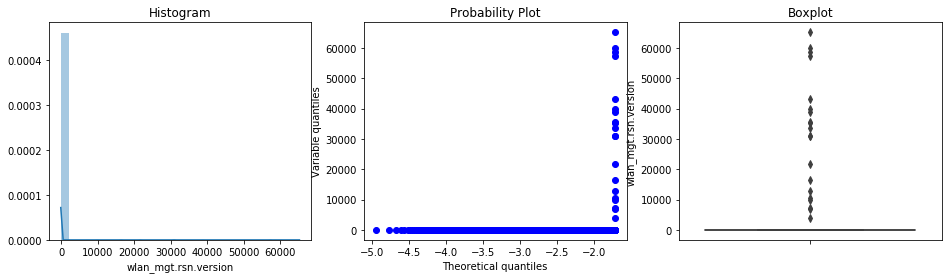

Feature: wlan_mgt.rsn.gcs.type

count    76944.000000
mean         2.032621
std          2.286164
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        255.000000
Name: wlan_mgt.rsn.gcs.type, dtype: float64
 


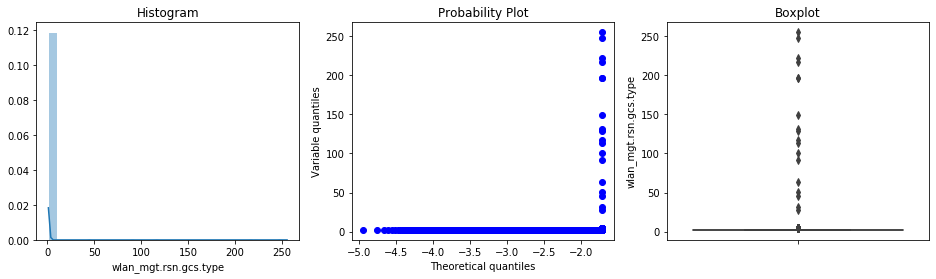

Feature: wlan_mgt.rsn.pcs.count

count    76944.000000
mean        11.678909
std        656.409061
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max      64704.000000
Name: wlan_mgt.rsn.pcs.count, dtype: float64
 


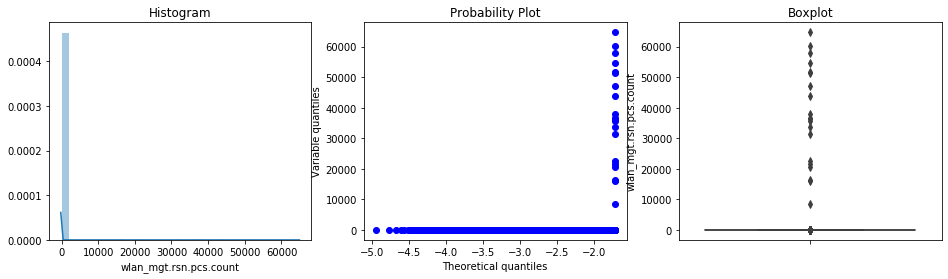

Feature: wlan_mgt.rsn.akms.count

count    76942.000000
mean        10.439097
std        671.834201
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      63111.000000
Name: wlan_mgt.rsn.akms.count, dtype: float64
 


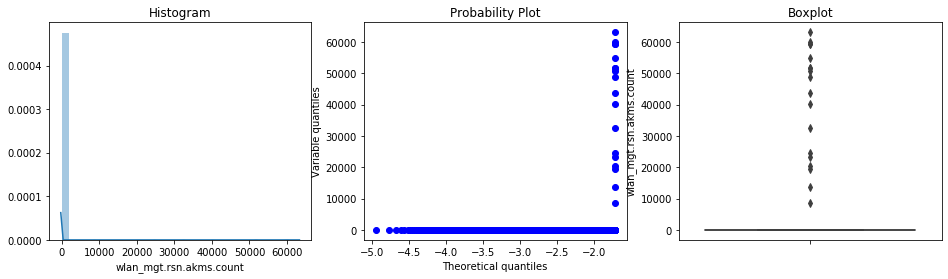

Feature: wlan_mgt.rsn.akms.type

count    76924.0
mean         2.0
std          0.0
min          2.0
25%          2.0
50%          2.0
75%          2.0
max          2.0
Name: wlan_mgt.rsn.akms.type, dtype: float64
 


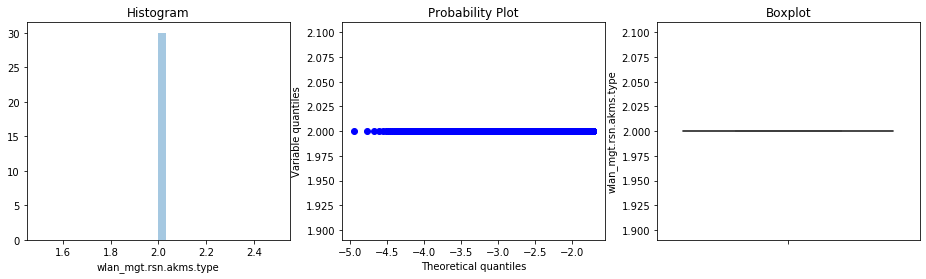

Feature: wlan_mgt.rsn.capabilities.preauth

count    76942.000000
mean         0.000611
std          0.024708
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: wlan_mgt.rsn.capabilities.preauth, dtype: float64
 


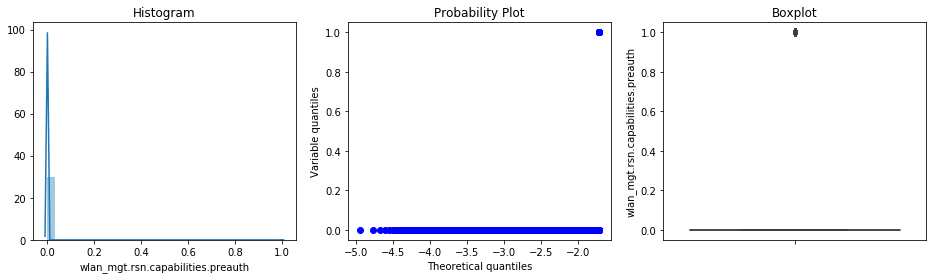

Feature: wlan_mgt.rsn.capabilities.no_pairwise

count    76942.000000
mean         0.000117
std          0.010815
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: wlan_mgt.rsn.capabilities.no_pairwise, dtype: float64
 


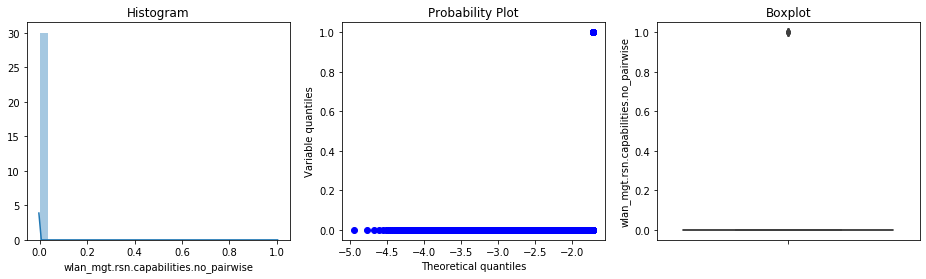

Feature: wlan_mgt.rsn.capabilities.mfpr

count    76942.000000
mean         0.000117
std          0.010815
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: wlan_mgt.rsn.capabilities.mfpr, dtype: float64
 


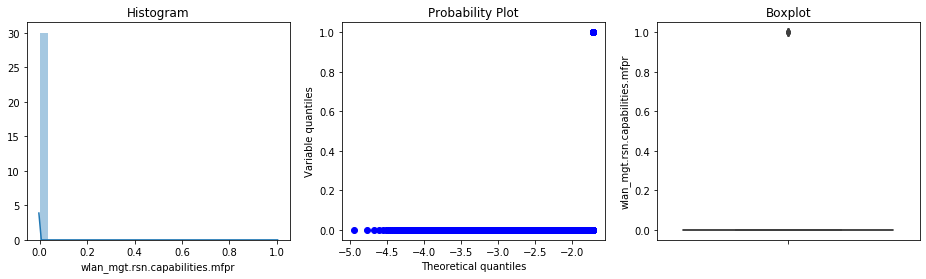

Feature: wlan_mgt.rsn.capabilities.mfpc

count    76942.000000
mean         0.000026
std          0.005098
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: wlan_mgt.rsn.capabilities.mfpc, dtype: float64
 


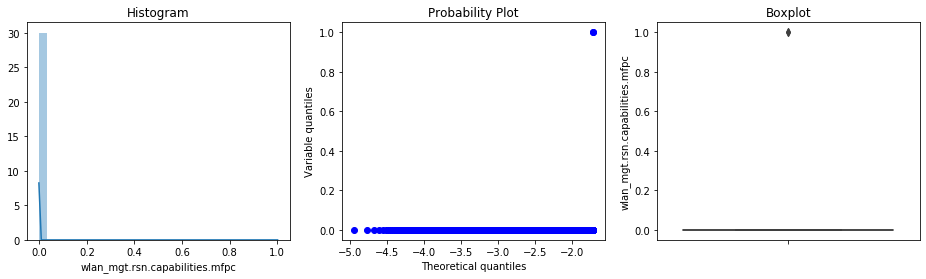

Feature: wlan_mgt.rsn.capabilities.peerkey

count    76942.000000
mean         0.000117
std          0.010815
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: wlan_mgt.rsn.capabilities.peerkey, dtype: float64
 


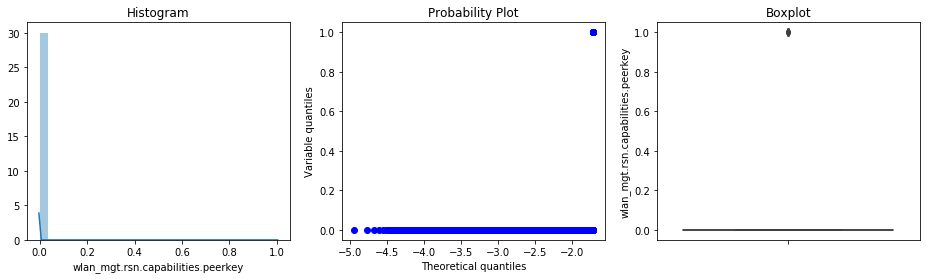

Feature: wlan_mgt.tcprep.trsmt_pow

count    39.000000
mean     18.025641
std       7.135852
min     -25.000000
25%      19.000000
50%      19.000000
75%      19.000000
max      25.000000
Name: wlan_mgt.tcprep.trsmt_pow, dtype: float64
 


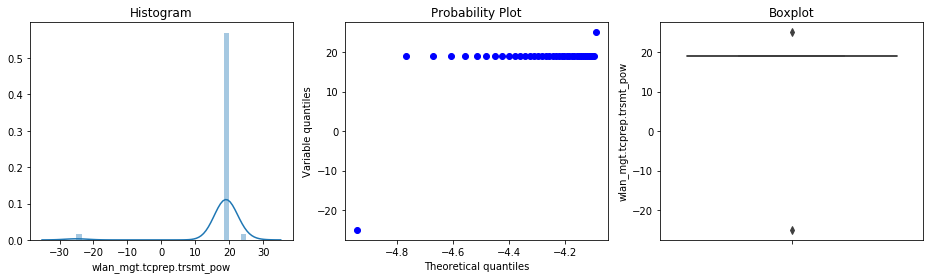

Feature: wlan_mgt.tcprep.link_mrg

count    39.000000
mean     -0.538462
std       3.362691
min     -21.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: wlan_mgt.tcprep.link_mrg, dtype: float64
 


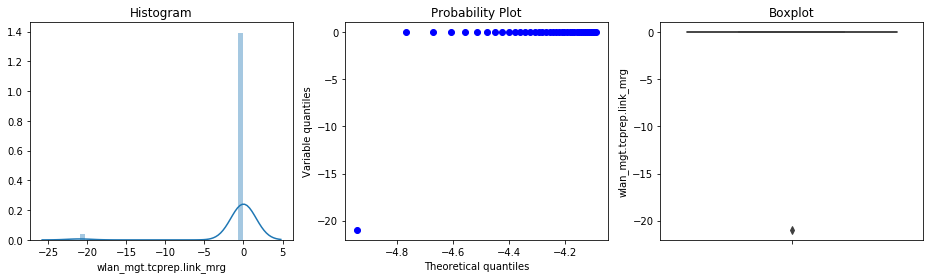

Feature: wlan.wep.key

count    885744.000000
mean          0.036835
std           0.193891
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: wlan.wep.key, dtype: float64
 


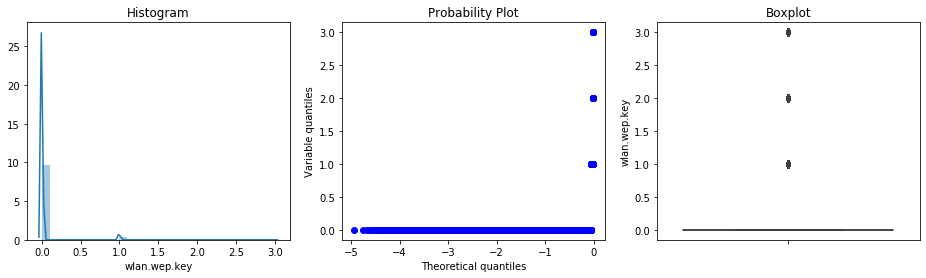

Feature: wlan.qos.tid

count    662341.000000
mean          0.768693
std           0.426397
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: wlan.qos.tid, dtype: float64
 


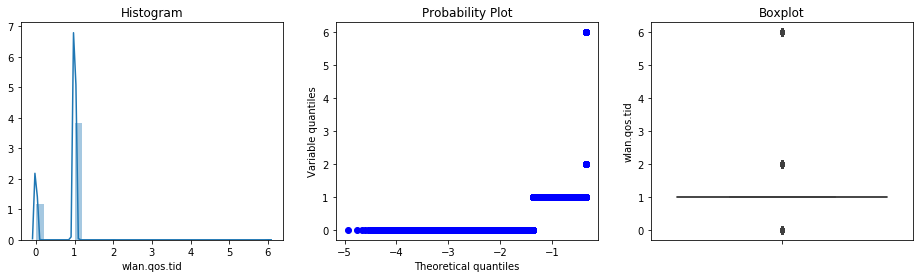

Feature: wlan.qos.priority

count    662341.000000
mean          0.768693
std           0.426397
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: wlan.qos.priority, dtype: float64
 


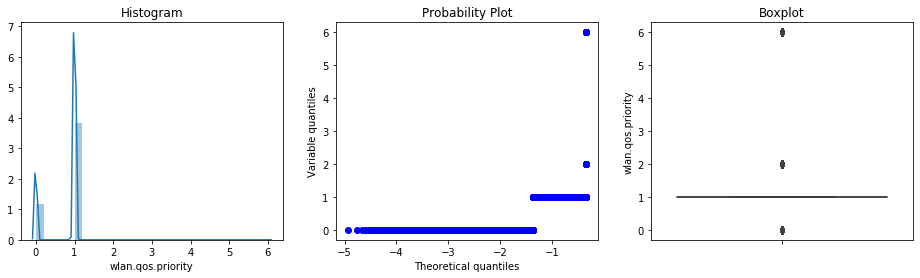

Feature: wlan.qos.eosp

count    515701.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: wlan.qos.eosp, dtype: float64
 


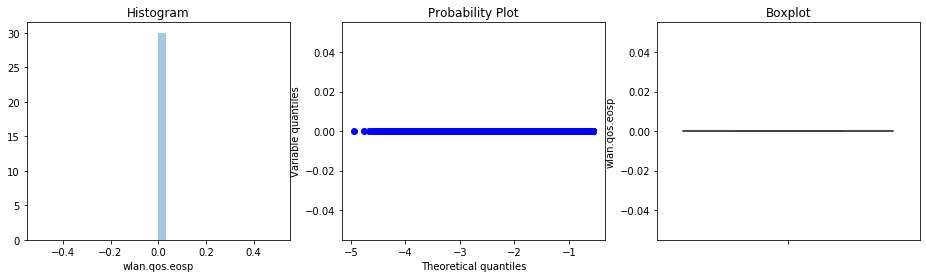

Feature: wlan.qos.amsdupresent

count    661349.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: wlan.qos.amsdupresent, dtype: float64
 


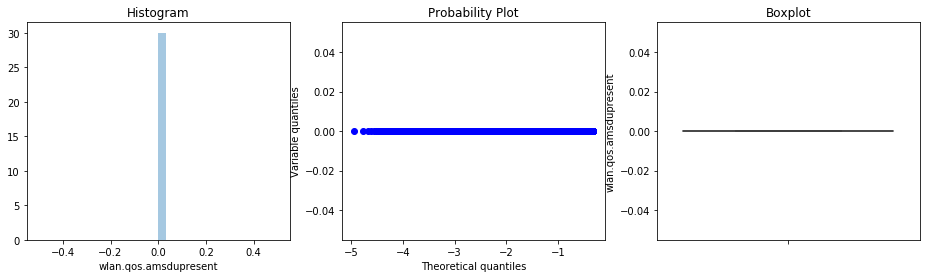

Feature: wlan.qos.buf_state_indicated_1

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: wlan.qos.buf_state_indicated_1, dtype: float64
 


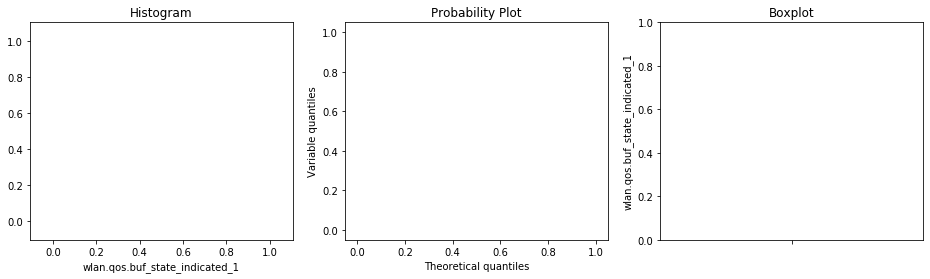

Feature: wlan.qos.bit4

count    146640.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: wlan.qos.bit4, dtype: float64
 


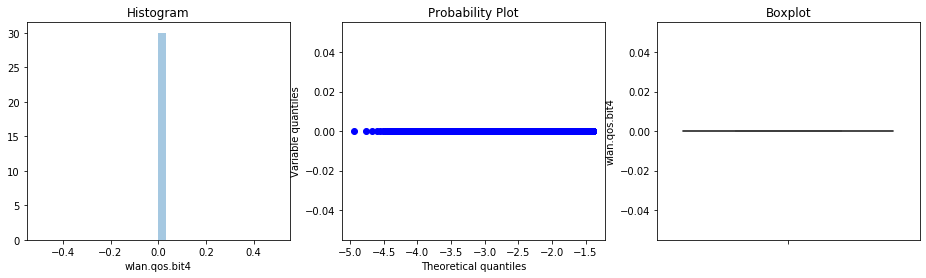

Feature: wlan.qos.txop_dur_req

count    146640.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: wlan.qos.txop_dur_req, dtype: float64
 


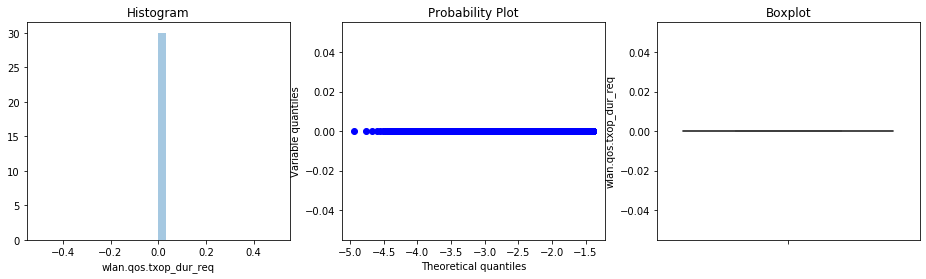

Feature: wlan.qos.buf_state_indicated_2

count    515701.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: wlan.qos.buf_state_indicated_2, dtype: float64
 


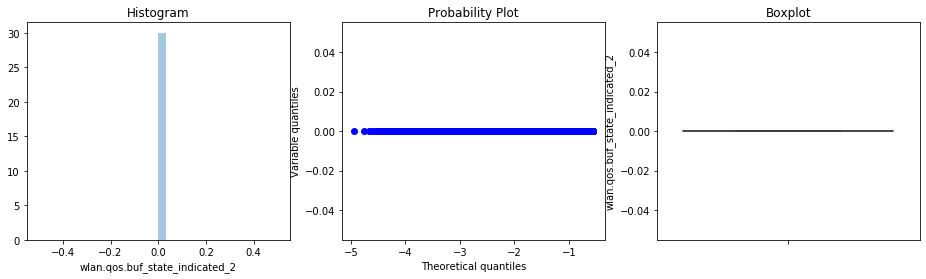

Feature: data.len

count    892554.000000
mean        896.970653
std         700.393956
min           3.000000
25%          60.000000
50%        1488.000000
75%        1490.000000
max        1508.000000
Name: data.len, dtype: float64
 


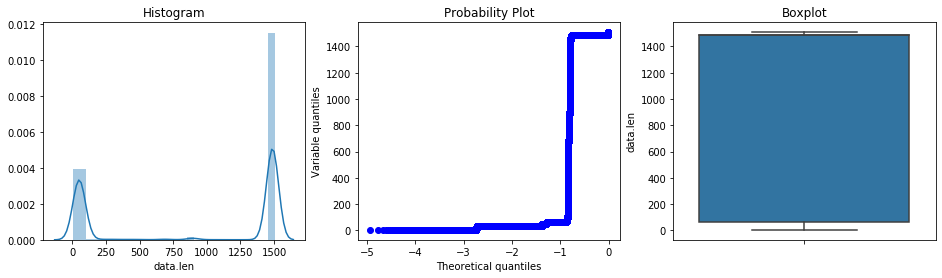

Feature: passed1second

count    1.795574e+06
mean     1.869770e+03
std      8.674454e+02
min      0.000000e+00
25%      1.027000e+03
50%      1.902000e+03
75%      2.524000e+03
max      3.599000e+03
Name: passed1second, dtype: float64
 


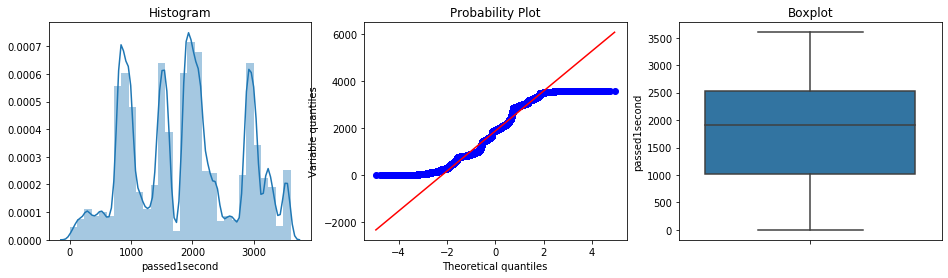

Feature: wlan.wep.iv_passed1second_count

count    1.795574e+06
mean     3.657486e+02
std      4.638257e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.020000e+02
75%      6.910000e+02
max      1.931000e+03
Name: wlan.wep.iv_passed1second_count, dtype: float64
 


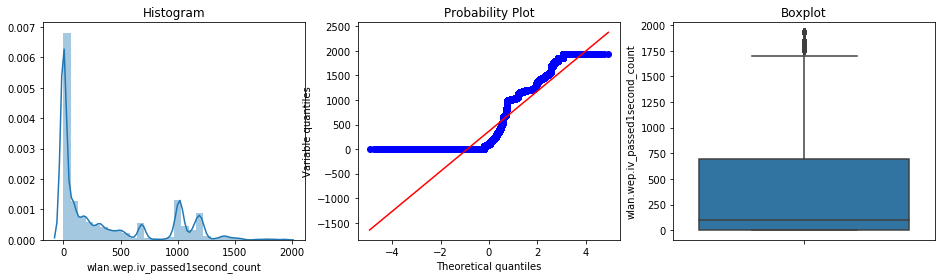

Feature: wlan.wep.icv_passed1second_count

count    1.795574e+06
mean     3.657472e+02
std      4.638267e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.020000e+02
75%      6.910000e+02
max      1.931000e+03
Name: wlan.wep.icv_passed1second_count, dtype: float64
 


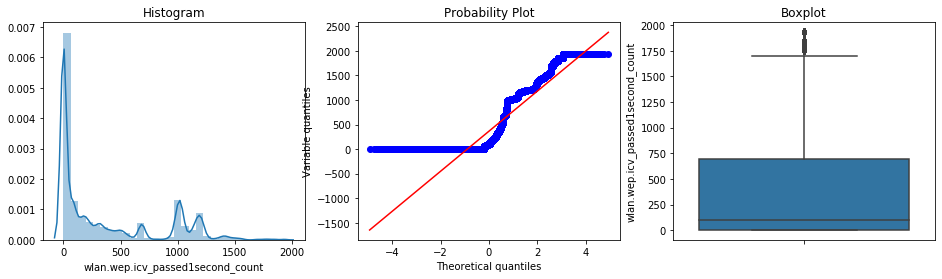

Feature: wlan.ta_passed1second_count

count    1.795574e+06
mean     4.647985e+02
std      3.607180e+02
min      1.000000e+00
25%      1.530000e+02
50%      3.760000e+02
75%      8.240000e+02
max      1.876000e+03
Name: wlan.ta_passed1second_count, dtype: float64
 


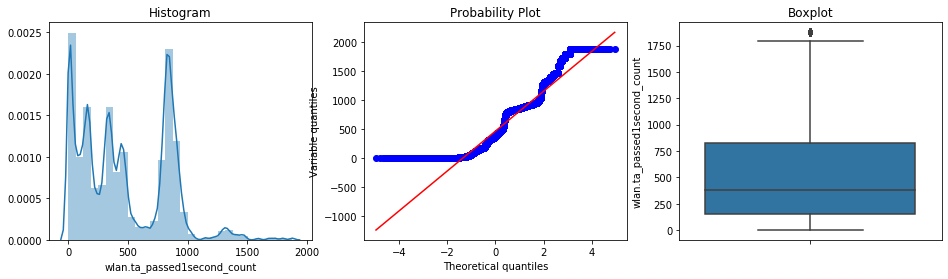

Feature: wlan.ra_passed1second_count

count    1.795574e+06
mean     5.743240e+02
std      4.120910e+02
min      1.000000e+00
25%      1.630000e+02
50%      5.570000e+02
75%      9.690000e+02
max      1.866000e+03
Name: wlan.ra_passed1second_count, dtype: float64
 


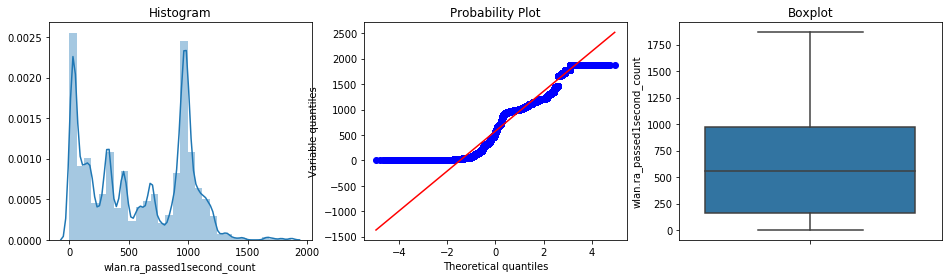

Feature: wlan.da_passed1second_count

count    1.795574e+06
mean     4.797938e+02
std      3.671114e+02
min      1.000000e+00
25%      1.510000e+02
50%      4.320000e+02
75%      8.190000e+02
max      1.876000e+03
Name: wlan.da_passed1second_count, dtype: float64
 


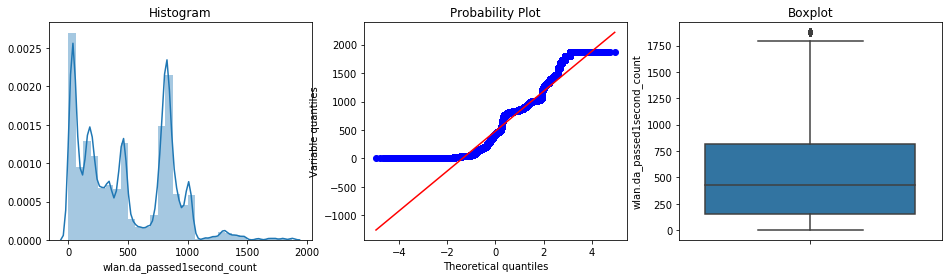

Feature: wlan.wep.iv_passed1second_count_change

count    1.795574e+06
mean     1.177169e+01
std      1.164780e+02
min     -1.041000e+03
25%     -1.000000e+00
50%      1.000000e+00
75%      9.000000e+00
max      1.147000e+03
Name: wlan.wep.iv_passed1second_count_change, dtype: float64
 


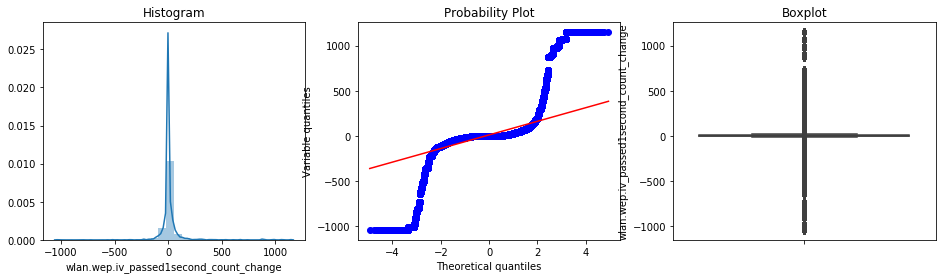

Feature: wlan.wep.icv_passed1second_count_change

count    1.795574e+06
mean     1.177092e+01
std      1.164783e+02
min     -1.041000e+03
25%     -1.000000e+00
50%      1.000000e+00
75%      9.000000e+00
max      1.147000e+03
Name: wlan.wep.icv_passed1second_count_change, dtype: float64
 


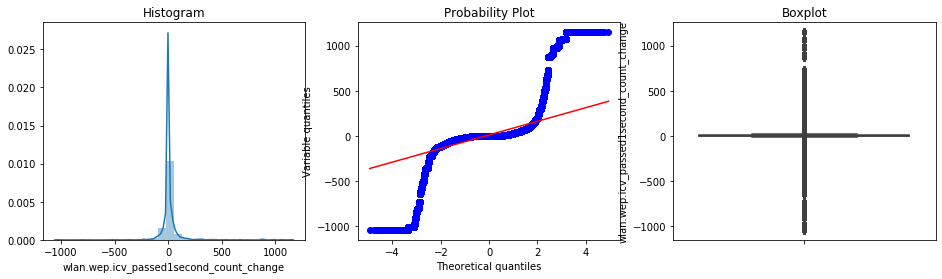

Feature: wlan.ta_passed1second_count_change

count    1.795574e+06
mean     2.026164e+01
std      1.379978e+02
min     -1.061000e+03
25%     -1.600000e+01
50%      3.000000e+00
75%      3.000000e+01
max      1.083000e+03
Name: wlan.ta_passed1second_count_change, dtype: float64
 


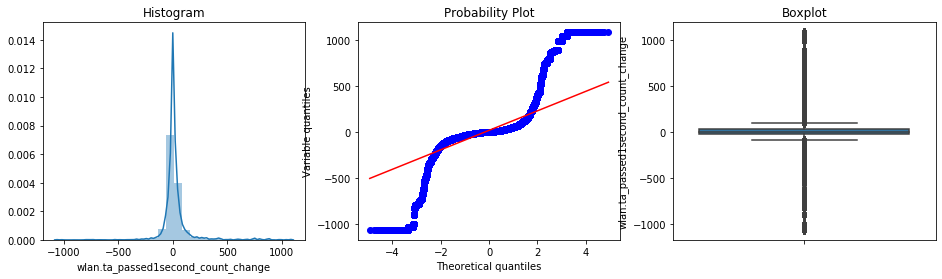

Feature: wlan.ra_passed1second_count_change

count    1.795574e+06
mean     2.706868e+01
std      1.714134e+02
min     -1.184000e+03
25%     -1.900000e+01
50%      4.000000e+00
75%      3.800000e+01
max      1.210000e+03
Name: wlan.ra_passed1second_count_change, dtype: float64
 


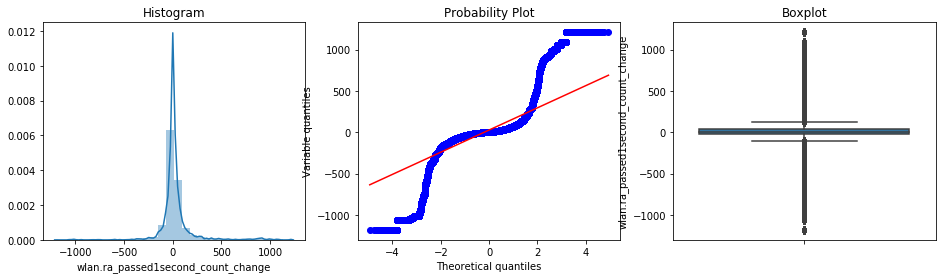

Feature: wlan.da_passed1second_count_change

count    1.795574e+06
mean     2.100336e+01
std      1.370255e+02
min     -1.061000e+03
25%     -1.700000e+01
50%      4.000000e+00
75%      3.200000e+01
max      1.083000e+03
Name: wlan.da_passed1second_count_change, dtype: float64
 


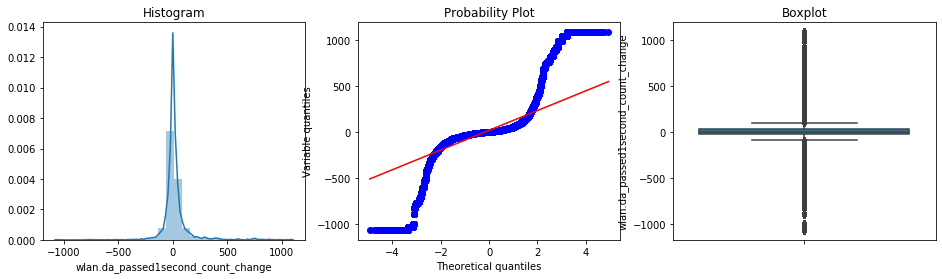

In [21]:
#### Numeric variables ####
for feat in NUMERIC:
    print( 'Feature:',feat)
    print('')
    print(X_train[feat].describe())
    print(' ')
    diagnostic_plots(X_train, feat)

In [22]:
for feat in CATEG:
    print( 'Feature:',feat)
    print('')
    print('Number of unique values:')
    print(X_train[feat].nunique())
    print('')
    print('Value distribution:')
    print((X_train[feat].value_counts().head(20)))
    print('')
    print('')

Feature: radiotap.present.reserved

Number of unique values:
1

Value distribution:
0x00000000    1795574
Name: radiotap.present.reserved, dtype: int64


Feature: wlan.fc.type_subtype

Number of unique values:
21

Value distribution:
0x28    661349
0x1d    416915
0x20    233909
0x0c    206058
0x08    133015
0x1c     35906
0x05     19077
0x24     18564
0x0b     15999
0x0a     15658
0x00     15484
0x01     12973
0x04      6879
0x1b      1275
0x1a      1192
0x2c       992
0x03       109
0x02        91
0x19        78
0x0d        28
Name: wlan.fc.type_subtype, dtype: int64


Feature: wlan.fc.ds

Number of unique values:
3

Value distribution:
0x00    880760
0x02    668983
0x01    245831
Name: wlan.fc.ds, dtype: int64


Feature: wlan.ra

Number of unique values:
1776

Value distribution:
c0:18:85:94:b6:55    538024
28:c6:8e:86:d3:d6    387517
ff:ff:ff:ff:ff:ff    286907
00:25:bc:ed:07:cf    203397
3c:5a:37:8c:9a:41    112358
20:64:32:54:c9:da     56038
b0:48:7a:e2:62:23     52991
b0:48:7a:e2

20

Value distribution:
0x49    4564
0x20     346
0x00      33
0x2a       1
0x59       1
0xdb       1
0xad       1
0x2c       1
0x25       1
0x68       1
0x93       1
0x33       1
0xc1       1
0x3a       1
0x03       1
0x2e       1
0x51       1
0xa0       1
0x95       1
0x6d       1
Name: wlan_mgt.country_info.environment, dtype: int64


Feature: wlan_mgt.rsn.capabilities.ptksa_replay_counter

Number of unique values:
4

Value distribution:
0x0000    76848
0x0003       53
0x0001       37
0x0002        4
Name: wlan_mgt.rsn.capabilities.ptksa_replay_counter, dtype: int64


Feature: wlan_mgt.rsn.capabilities.gtksa_replay_counter

Number of unique values:
4

Value distribution:
0x0000    76929
0x0001        5
0x0002        4
0x0003        4
Name: wlan_mgt.rsn.capabilities.gtksa_replay_counter, dtype: int64


Feature: wlan.wep.iv

Number of unique values:
705130

Value distribution:
Missing     944819
0x28ce93     64690
0x99309a      9097
0x091442      8649
0x536c7e      8479
0x5be630      